---
## 1. Setup and Imports

In [182]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, Tuple, List
import warnings
import json
from datetime import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ML imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, roc_auc_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    brier_score_loss, log_loss, average_precision_score
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import lightgbm as lgb

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("XGBoost: Available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost: Not available (pip install xgboost)")

# Optuna for hyperparameter tuning
try:
    import optuna
    from optuna.samplers import TPESampler
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    OPTUNA_AVAILABLE = True
    print("Optuna: Available")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna: Not available (using default hyperparameters)")

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("\nAll imports successful!")

XGBoost: Available
Optuna: Available

All imports successful!


---
## 2. Configuration

In [183]:
# ========================================
# REAL DATA PATHS & FILTERS
# ========================================

# Real Normal Data (HDBSCAN discovered)
REAL_NORMAL_TRAIN_PATH = '/home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_discovered.csv'
REAL_NORMAL_LABEL_COLUMN = 'discovered_label'
REAL_NORMAL_FILTER_VALUES = ['likely_normal']

REAL_NORMAL_TEST_PATH = '/home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN/rrc04_updates_20251116_extracted_discovered.csv'
REAL_NORMAL_TEST_LABEL_COLUMN = 'discovered_label'
REAL_NORMAL_TEST_FILTER_VALUES = ['likely_normal']

# Real Anomaly Data (Reinforced confidence labels)
REAL_ANOMALY_PATH = '/home/smotaali/BGP_Traffic_Generation/RIPE/RIPE_INCIDENTS_EXTENDED/all_incidents_anomalies_extended_reinforced.csv'
REAL_ANOMALY_LABEL_COLUMN = 'reinforced_confidence_label'
REAL_ANOMALY_FILTER_VALUES = ['medium_confidence', 'high_confidence', 'very_high_confidence']

REAL_ANOMALY_TEST_PATH = '/home/smotaali/BGP_Traffic_Generation/RIPE/RIPE_INCIDENTS/all_incidents_anomalies_reinforced_v2.csv'
REAL_ANOMALY_TEST_LABEL_COLUMN = 'reinforced_confidence_label'  # Adjust if different
REAL_ANOMALY_TEST_FILTER_VALUES = ['medium_confidence', 'high_confidence', 'very_high_confidence']  # Adjust if different


# ========================================
# SYNTHETIC DATA PATHS
# ========================================

SYNTHETIC_NORMAL_PATH = '/home/smotaali/BGP_Traffic_Generation/results_zend/SMOTE_enhanced/synthetic_likely_normal_enhanced_kmeans.csv'
SYNTHETIC_ANOMALY_PATH = '/home/smotaali/BGP_Traffic_Generation/synthetic_anomaly_data/SMOTE_enhanced/k_means_smote_anomaly.csv'

# ========================================
# OUTPUT DIRECTORY
# ========================================
OUTPUT_DIR = '/home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote'

# ========================================
# TRAINING SETTINGS
# ========================================
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_TRIALS = 30
CV_FOLDS = 5
USE_CALIBRATION = True
BALANCE_DATA = True  # Balance datasets to have equal normal/anomaly samples

# ========================================
# FEATURE COLUMNS
# ========================================
FEATURE_COLUMNS = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0',
    'origin_2', 'origin_changes', 'as_path_max', 'unique_as_path_max',
    'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0',
    'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3',
    'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6',
    'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'imp_wd',
    'imp_wd_spath', 'imp_wd_dpath', 'number_rare_ases', 'rare_ases_avg',
    'flaps', 'nadas'
]

# Create output directory
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Storage for all hyperparameters
all_hyperparameters = {}

print("Configuration loaded.")
print(f"Balance data: {BALANCE_DATA}")

Configuration loaded.
Balance data: True


---
## 3. Load Real Data (with Filtering and Balancing)

In [184]:
# Load Real Normal Data
print("="*60)
print("Loading REAL NORMAL Data")
print("="*60)

df_real_normal_raw = pd.read_csv(REAL_NORMAL_PATH)
print(f"Raw shape: {df_real_normal_raw.shape}")
print(f"Columns: {df_real_normal_raw.columns.tolist()}")
print(f"\nLabel column '{REAL_NORMAL_LABEL_COLUMN}' distribution:")
print(df_real_normal_raw[REAL_NORMAL_LABEL_COLUMN].value_counts())

# Filter for specified labels
df_real_normal = df_real_normal_raw[df_real_normal_raw[REAL_NORMAL_LABEL_COLUMN].isin(REAL_NORMAL_FILTER_VALUES)].copy()
print(f"\nAfter filtering for {REAL_NORMAL_FILTER_VALUES}: {len(df_real_normal)} samples")

Loading REAL NORMAL Data
Raw shape: (86387, 38)
Columns: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'number_rare_ases', 'rare_ases_avg', 'flaps', 'nadas', 'label', 'window_start', 'window_end', 'iso_forest_score', 'lof_score', 'statistical_score', 'elliptic_score', 'cluster', 'anomaly_votes', 'consensus_score', 'discovered_label']

Label column 'discovered_label' distribution:
discovered_label
likely_normal              67940
uncertain                  11248
high_confidence_anomaly     5168
likely_anomaly              2031
Name: count, dtype: int64

After filtering for ['likely_normal']: 67

In [185]:
# Load Real Anomaly Data
print("="*60)
print("Loading REAL ANOMALY Data")
print("="*60)

df_real_anomaly_raw = pd.read_csv(REAL_ANOMALY_PATH)
print(f"Raw shape: {df_real_anomaly_raw.shape}")
print(f"\nLabel column '{REAL_ANOMALY_LABEL_COLUMN}' distribution:")
print(df_real_anomaly_raw[REAL_ANOMALY_LABEL_COLUMN].value_counts())

# Filter for specified labels
df_real_anomaly = df_real_anomaly_raw[df_real_anomaly_raw[REAL_ANOMALY_LABEL_COLUMN].isin(REAL_ANOMALY_FILTER_VALUES)].copy()
print(f"\nAfter filtering for {REAL_ANOMALY_FILTER_VALUES}: {len(df_real_anomaly)} samples")

Loading REAL ANOMALY Data
Raw shape: (185586, 48)

Label column 'reinforced_confidence_label' distribution:
reinforced_confidence_label
needs_review            157120
low_confidence            9668
medium_confidence         7939
very_high_confidence      7134
high_confidence           3725
Name: count, dtype: int64

After filtering for ['medium_confidence', 'high_confidence', 'very_high_confidence']: 18798 samples


In [186]:
# Combine Real Normal and Anomaly Data (BALANCED)
print("="*60)
print("Combining REAL Data (BALANCED)")
print("="*60)

# Find common features
common_features = [col for col in FEATURE_COLUMNS 
                   if col in df_real_normal.columns and col in df_real_anomaly.columns]
print(f"Common features: {len(common_features)}")

# Extract features
X_real_normal_full = df_real_normal[common_features].fillna(0)
X_real_anomaly_full = df_real_anomaly[common_features].fillna(0)

# ========================================
# BALANCE REAL DATA
# ========================================
np.random.seed(RANDOM_STATE)

n_normal = len(X_real_normal_full)
n_anomaly = len(X_real_anomaly_full)
n_samples_per_class = min(n_normal, n_anomaly) if BALANCE_DATA else max(n_normal, n_anomaly)

print(f"\nOriginal counts: Normal={n_normal}, Anomaly={n_anomaly}")
print(f"Balancing to {n_samples_per_class} samples per class...")

# Randomly sample from each class
normal_indices = np.random.choice(n_normal, size=min(n_samples_per_class, n_normal), replace=False)
anomaly_indices = np.random.choice(n_anomaly, size=min(n_samples_per_class, n_anomaly), replace=False)

X_real_normal = X_real_normal_full.iloc[normal_indices].reset_index(drop=True)
X_real_anomaly = X_real_anomaly_full.iloc[anomaly_indices].reset_index(drop=True)

# Create binary labels (0 = normal, 1 = anomaly)
y_real_normal = np.zeros(len(X_real_normal), dtype=int)
y_real_anomaly = np.ones(len(X_real_anomaly), dtype=int)

# Combine
X_real = pd.concat([X_real_normal, X_real_anomaly], ignore_index=True)
y_real = np.concatenate([y_real_normal, y_real_anomaly])

# Shuffle
shuffle_idx = np.random.permutation(len(X_real))
X_real = X_real.iloc[shuffle_idx].reset_index(drop=True)
y_real = y_real[shuffle_idx]

print(f"\nCombined Real Data (BALANCED):")
print(f"  Total samples: {len(X_real)}")
print(f"  Normal: {sum(y_real==0)} ({sum(y_real==0)/len(y_real)*100:.1f}%)")
print(f"  Anomaly: {sum(y_real==1)} ({sum(y_real==1)/len(y_real)*100:.1f}%)")

Combining REAL Data (BALANCED)
Common features: 27

Original counts: Normal=67940, Anomaly=18798
Balancing to 18798 samples per class...

Combined Real Data (BALANCED):
  Total samples: 37596
  Normal: 18798 (50.0%)
  Anomaly: 18798 (50.0%)


---
## 4. Load Synthetic Data (Balanced to Match Real Data)



In [187]:
# Load Synthetic Data
print("="*60)
print("Loading SYNTHETIC Data")
print("="*60)

# Load synthetic normal
print("\n--- Synthetic Normal ---")
df_synth_normal = pd.read_csv(SYNTHETIC_NORMAL_PATH)
print(f"Shape: {df_synth_normal.shape}")
print(f"All columns: {df_synth_normal.columns.tolist()}")
print(f"NOTE: Extra columns (sequence_id, timestamp, label, etc.) are metadata, NOT features")

# Load synthetic anomaly
print("\n--- Synthetic Anomaly ---")
df_synth_anomaly = pd.read_csv(SYNTHETIC_ANOMALY_PATH)
print(f"Shape: {df_synth_anomaly.shape}")

# Find common features across ALL datasets
common_features_all = [col for col in common_features 
                       if col in df_synth_normal.columns and col in df_synth_anomaly.columns]
print(f"\nCommon FEATURE columns across all datasets: {len(common_features_all)}")
print(f"Features: {common_features_all}")

# Update X_real to use only common features
X_real = X_real[common_features_all]

# Extract features from synthetic data
X_synth_normal_full = df_synth_normal[common_features_all].fillna(0)
X_synth_anomaly_full = df_synth_anomaly[common_features_all].fillna(0)

# ========================================
# BALANCE SYNTHETIC DATA TO MATCH REAL DATA
# ========================================
n_real_normal = sum(y_real == 0)
n_real_anomaly = sum(y_real == 1)

print(f"\nReal data counts: Normal={n_real_normal}, Anomaly={n_real_anomaly}")
print(f"Synthetic original: Normal={len(X_synth_normal_full)}, Anomaly={len(X_synth_anomaly_full)}")

# Sample synthetic to match real data size
n_synth_normal = min(len(X_synth_normal_full), n_real_normal)
n_synth_anomaly = min(len(X_synth_anomaly_full), n_real_anomaly)

print(f"Balancing synthetic to: Normal={n_synth_normal}, Anomaly={n_synth_anomaly}")

synth_normal_idx = np.random.choice(len(X_synth_normal_full), size=n_synth_normal, replace=False)
synth_anomaly_idx = np.random.choice(len(X_synth_anomaly_full), size=n_synth_anomaly, replace=False)

X_synth_normal = X_synth_normal_full.iloc[synth_normal_idx].reset_index(drop=True)
X_synth_anomaly = X_synth_anomaly_full.iloc[synth_anomaly_idx].reset_index(drop=True)

# Create labels
y_synth_normal = np.zeros(len(X_synth_normal), dtype=int)
y_synth_anomaly = np.ones(len(X_synth_anomaly), dtype=int)

# Combine synthetic data
X_synthetic = pd.concat([X_synth_normal, X_synth_anomaly], ignore_index=True)
y_synthetic = np.concatenate([y_synth_normal, y_synth_anomaly])

# Shuffle
shuffle_idx = np.random.permutation(len(X_synthetic))
X_synthetic = X_synthetic.iloc[shuffle_idx].reset_index(drop=True)
y_synthetic = y_synthetic[shuffle_idx]

print(f"\nCombined Synthetic Data (BALANCED):")
print(f"  Total samples: {len(X_synthetic)}")
print(f"  Normal: {sum(y_synthetic==0)} ({sum(y_synthetic==0)/len(y_synthetic)*100:.1f}%)")
print(f"  Anomaly: {sum(y_synthetic==1)} ({sum(y_synthetic==1)/len(y_synthetic)*100:.1f}%)")

Loading SYNTHETIC Data

--- Synthetic Normal ---


Shape: (19994, 33)
All columns: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'nadas', 'flaps', 'edit_distance_avg', 'rare_ases_avg', 'timestamp', 'label', 'discovered_label', 'generation_method', 'log_transform_used', 'bgp_constraints_enforced']
NOTE: Extra columns (sequence_id, timestamp, label, etc.) are metadata, NOT features

--- Synthetic Anomaly ---
Shape: (19993, 29)

Common FEATURE columns across all datasets: 27
Features: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distan

In [188]:
# ========================================
# LOAD SEPARATE TEST DATA FOR TRTR (rrc04)
# ========================================
print("="*70)
print("Loading SEPARATE TEST Data for TRTR (rrc04)")
print("="*70)

# Load Test Normal
df_test_normal_raw = pd.read_csv(REAL_NORMAL_TEST_PATH)
df_test_normal = df_test_normal_raw[df_test_normal_raw[REAL_NORMAL_LABEL_COLUMN].isin(REAL_NORMAL_FILTER_VALUES)].copy()
print(f"Test Normal: {len(df_test_normal)} samples")

# Load Test Anomaly
df_test_anomaly_raw = pd.read_csv(REAL_ANOMALY_TEST_PATH)
# Check columns and filter
print(f"Test Anomaly columns: {df_test_anomaly_raw.columns.tolist()}")
if REAL_ANOMALY_LABEL_COLUMN in df_test_anomaly_raw.columns:
    df_test_anomaly = df_test_anomaly_raw[df_test_anomaly_raw[REAL_ANOMALY_LABEL_COLUMN].isin(REAL_ANOMALY_FILTER_VALUES)].copy()
else:
    print(f"Using all anomaly data (no filter column found)")
    df_test_anomaly = df_test_anomaly_raw.copy()
print(f"Test Anomaly: {len(df_test_anomaly)} samples")

# Extract and balance
X_test_normal_trtr = df_test_normal[common_features_all].fillna(0)
X_test_anomaly_trtr = df_test_anomaly[common_features_all].fillna(0)

n_test_normal = len(X_test_normal_trtr)
n_test_anomaly = len(X_test_anomaly_trtr)
n_test_per_class = min(len(X_synth_normal_full), n_real_normal)

print(f"Balancing test data to {n_test_per_class} per class...")

test_normal_idx = np.random.choice(n_test_normal, size=n_test_per_class, replace=False)
test_anomaly_idx = np.random.choice(n_test_anomaly, size=n_test_per_class, replace=False)

X_test_normal_trtr = X_test_normal_trtr.iloc[test_normal_idx].reset_index(drop=True)
X_test_anomaly_trtr = X_test_anomaly_trtr.iloc[test_anomaly_idx].reset_index(drop=True)

# Combine
X_test_real_trtr = pd.concat([X_test_normal_trtr, X_test_anomaly_trtr], ignore_index=True)
y_test_real_trtr = np.concatenate([np.zeros(len(X_test_normal_trtr)), np.ones(len(X_test_anomaly_trtr))])

# Shuffle
shuffle_idx = np.random.permutation(len(X_test_real_trtr))
X_test_real_trtr = X_test_real_trtr.iloc[shuffle_idx].reset_index(drop=True)
y_test_real_trtr = y_test_real_trtr[shuffle_idx]

# Scale using same scaler
X_test_real_trtr_scaled = scaler.transform(X_test_real_trtr)

print(f"\nTRTR Test Data (rrc04): {len(X_test_real_trtr)} samples")
print(f"  Normal: {sum(y_test_real_trtr==0)}, Anomaly: {sum(y_test_real_trtr==1)}")


Loading SEPARATE TEST Data for TRTR (rrc04)


Test Normal: 67940 samples
Test Anomaly columns: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'rare_ases_avg', 'nadas', 'flaps', 'label', 'Incident', 'window_start', 'window_end', 'method_agreement_count', 'reinforced_confidence_label', 'ensemble_score', 'classifier_confidence', 'incident_coherence', 'score_mahalanobis', 'flag_mahalanobis', 'score_ocsvm', 'flag_ocsvm', 'score_statistical', 'flag_statistical', 'score_lof', 'flag_lof', 'score_isolation_forest', 'flag_isolation_forest', 'score_elliptic_envelope', 'flag_elliptic_envelope']
Test Anomaly: 21439 samples
Balancing

---
## 5. Data Splitting and Scaling

In [189]:
# Split REAL data into train and test
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_real
)

# Split SYNTHETIC data into train and test (for TRTS)
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synthetic, y_synthetic, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_synthetic
)

print("Data Split:")
print(f"  Real Train:      {len(X_train_real)} (Normal: {sum(y_train_real==0)}, Anomaly: {sum(y_train_real==1)})")
print(f"  Real Test:       {len(X_test_real)} (Normal: {sum(y_test_real==0)}, Anomaly: {sum(y_test_real==1)})")
print(f"  Synthetic Train: {len(X_train_synth)} (Normal: {sum(y_train_synth==0)}, Anomaly: {sum(y_train_synth==1)})")
print(f"  Synthetic Test:  {len(X_test_synth)} (Normal: {sum(y_test_synth==0)}, Anomaly: {sum(y_test_synth==1)})")

# Scale features (fit on real training data)
scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real)
X_test_real_scaled = scaler.transform(X_test_real)
X_train_synth_scaled = scaler.transform(X_train_synth)
X_test_synth_scaled = scaler.transform(X_test_synth)

print(TEST_SIZE)

Data Split:
  Real Train:      30076 (Normal: 15038, Anomaly: 15038)
  Real Test:       7520 (Normal: 3760, Anomaly: 3760)
  Synthetic Train: 30076 (Normal: 15038, Anomaly: 15038)
  Synthetic Test:  7520 (Normal: 3760, Anomaly: 3760)
0.2


In [190]:
# ========================================
# LOAD SEPARATE TEST DATA FOR TRTR (rrc04)
# ========================================
print("="*70)
print("Loading SEPARATE TEST Data for TRTR (rrc04)")
print("="*70)

# Load Test Normal (rrc04)
df_test_normal_raw = pd.read_csv(REAL_NORMAL_TEST_PATH)
df_test_normal = df_test_normal_raw[df_test_normal_raw[REAL_NORMAL_LABEL_COLUMN].isin(REAL_NORMAL_FILTER_VALUES)].copy()
print(f"Test Normal: {len(df_test_normal)} samples")

# Load Test Anomaly
df_test_anomaly_raw = pd.read_csv(REAL_ANOMALY_TEST_PATH)
if REAL_ANOMALY_LABEL_COLUMN in df_test_anomaly_raw.columns:
    df_test_anomaly = df_test_anomaly_raw[df_test_anomaly_raw[REAL_ANOMALY_LABEL_COLUMN].isin(REAL_ANOMALY_FILTER_VALUES)].copy()
else:
    df_test_anomaly = df_test_anomaly_raw.copy()
print(f"Test Anomaly: {len(df_test_anomaly)} samples")

# Extract features
X_test_normal_trtr = df_test_normal[common_features_all].fillna(0)
X_test_anomaly_trtr = df_test_anomaly[common_features_all].fillna(0)

# Balance
n_test_per_class = sum(y_test_real == 0)
print(f"Balancing to {n_test_per_class} per class...")
min(len(X_synth_normal_full), n_real_normal)
X_test_normal_trtr = X_test_normal_trtr.sample(n=n_test_per_class, random_state=RANDOM_STATE).reset_index(drop=True)
X_test_anomaly_trtr = X_test_anomaly_trtr.sample(n=n_test_per_class, random_state=RANDOM_STATE).reset_index(drop=True)

# Combine
X_test_real_trtr = pd.concat([X_test_normal_trtr, X_test_anomaly_trtr], ignore_index=True)
y_test_real_trtr = np.array([0]*len(X_test_normal_trtr) + [1]*len(X_test_anomaly_trtr))

# Shuffle
shuffle_idx = np.random.permutation(len(X_test_real_trtr))
X_test_real_trtr = X_test_real_trtr.iloc[shuffle_idx].reset_index(drop=True)
y_test_real_trtr = y_test_real_trtr[shuffle_idx]

# Scale (using same scaler fitted on training data)
X_test_real_trtr_scaled = scaler.transform(X_test_real_trtr)

print(f"TRTR Test Data: {len(X_test_real_trtr)} (Normal: {n_test_per_class}, Anomaly: {n_test_per_class})")


Loading SEPARATE TEST Data for TRTR (rrc04)
Test Normal: 67940 samples
Test Anomaly: 21439 samples
Balancing to 3760 per class...
TRTR Test Data: 7520 (Normal: 3760, Anomaly: 3760)


---
## 6. Hyperparameter Tuning Functions

In [191]:
def tune_random_forest(X, y, n_trials=30, random_state=42):
    """Tune Random Forest using Optuna."""
    if not OPTUNA_AVAILABLE:
        return {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5,
                'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced',
                'random_state': random_state, 'n_jobs': -1}

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'class_weight': 'balanced', 'random_state': random_state, 'n_jobs': -1
        }
        model = RandomForestClassifier(**params)
        cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=random_state)
        return cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best = study.best_params
    best.update({'class_weight': 'balanced', 'random_state': random_state, 'n_jobs': -1})
    print(f"  Best CV F1: {study.best_value:.4f}")
    return best


def tune_lightgbm(X, y, n_trials=30, random_state=42):
    """Tune LightGBM using Optuna."""
    if not OPTUNA_AVAILABLE:
        return {'objective': 'binary', 'n_estimators': 200, 'max_depth': 10,
                'learning_rate': 0.1, 'class_weight': 'balanced', 'random_state': random_state, 'verbose': -1}

    def objective(trial):
        params = {
            'objective': 'binary', 'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'num_leaves': trial.suggest_int('num_leaves', 10, 150),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'class_weight': 'balanced', 'random_state': random_state, 'verbose': -1
        }
        model = lgb.LGBMClassifier(**params)
        cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=random_state)
        return cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best = study.best_params
    best.update({'objective': 'binary', 'boosting_type': 'gbdt', 'class_weight': 'balanced',
                 'random_state': random_state, 'verbose': -1})
    print(f"  Best CV F1: {study.best_value:.4f}")
    return best


def tune_xgboost(X, y, n_trials=30, random_state=42):
    """Tune XGBoost using Optuna."""
    if not OPTUNA_AVAILABLE or not XGBOOST_AVAILABLE:
        return {'objective': 'binary:logistic', 'n_estimators': 200, 'max_depth': 6,
                'learning_rate': 0.1, 'random_state': random_state,
                'eval_metric': 'logloss'}

    # Calculate scale_pos_weight for imbalanced data
    scale_pos_weight = sum(y == 0) / sum(y == 1) if sum(y == 1) > 0 else 1

    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'scale_pos_weight': scale_pos_weight,
            'random_state': random_state, 'use_label_encoder': False, 'eval_metric': 'logloss'
        }
        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=random_state)
        return cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best = study.best_params
    best.update({'objective': 'binary:logistic', 'scale_pos_weight': scale_pos_weight,
                 'random_state': random_state, 'eval_metric': 'logloss'})
    print(f"  Best CV F1: {study.best_value:.4f}")
    return best


print("Hyperparameter tuning functions defined.")

Hyperparameter tuning functions defined.


---
## 7. Evaluation Metrics

In [192]:
def compute_ece(y_true, y_prob, n_bins=10):
    """Compute Expected Calibration Error."""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        in_bin = (y_prob >= bin_boundaries[i]) & (y_prob < bin_boundaries[i + 1])
        if np.sum(in_bin) > 0:
            ece += np.mean(in_bin) * np.abs(np.mean(y_true[in_bin]) - np.mean(y_prob[in_bin]))
    return ece


def compute_all_metrics(y_true, y_pred, y_prob):
    """Compute all evaluation metrics."""
    return {
        'f1_score': f1_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'auroc': roc_auc_score(y_true, y_prob),
        'auprc': average_precision_score(y_true, y_prob),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'brier_score': brier_score_loss(y_true, y_prob),
        'ece': compute_ece(y_true, y_prob),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

print("Metrics functions defined.")

Metrics functions defined.


---
## 8. Train All Models for All Regimes

In [193]:
# Storage for results
all_results = {'TRTR': {}, 'TSTR': {}, 'TRTS': {}}
all_models = {'TRTR': {}, 'TSTR': {}, 'TRTS': {}}

MODEL_CLASSES = {
    'RandomForest': (RandomForestClassifier, tune_random_forest),
    'LightGBM': (lgb.LGBMClassifier, tune_lightgbm),
}

if XGBOOST_AVAILABLE:
    MODEL_CLASSES['XGBoost'] = (xgb.XGBClassifier, tune_xgboost)

print(f"Models to train: {list(MODEL_CLASSES.keys())}")

Models to train: ['RandomForest', 'LightGBM', 'XGBoost']


In [194]:
# ========================================
# LOAD SEPARATE TEST DATA FOR TRTR (rrc04)
# ========================================
print("="*70)
print("Loading SEPARATE TEST Data for TRTR (rrc04)")
print("="*70)

# Load Test Normal
df_test_normal_raw = pd.read_csv(REAL_NORMAL_TEST_PATH)
df_test_normal = df_test_normal_raw[df_test_normal_raw[REAL_NORMAL_LABEL_COLUMN].isin(REAL_NORMAL_FILTER_VALUES)].copy()
print(f"Test Normal: {len(df_test_normal)} samples")

# Load Test Anomaly
df_test_anomaly_raw = pd.read_csv(REAL_ANOMALY_TEST_PATH)
# Check columns and filter
print(f"Test Anomaly columns: {df_test_anomaly_raw.columns.tolist()}")
if REAL_ANOMALY_LABEL_COLUMN in df_test_anomaly_raw.columns:
    df_test_anomaly = df_test_anomaly_raw[df_test_anomaly_raw[REAL_ANOMALY_LABEL_COLUMN].isin(REAL_ANOMALY_FILTER_VALUES)].copy()
else:
    print(f"Using all anomaly data (no filter column found)")
    df_test_anomaly = df_test_anomaly_raw.copy()
print(f"Test Anomaly: {len(df_test_anomaly)} samples")

# Extract and balance
X_test_normal_trtr = df_test_normal[common_features_all].fillna(0)
X_test_anomaly_trtr = df_test_anomaly[common_features_all].fillna(0)

n_test_normal = len(X_test_normal_trtr)
n_test_anomaly = len(X_test_anomaly_trtr)
n_test_per_class = min(n_test_normal, n_test_anomaly)

print(f"Balancing test data to {n_test_per_class} per class...")

test_normal_idx = np.random.choice(n_test_normal, size=n_test_per_class, replace=False)
test_anomaly_idx = np.random.choice(n_test_anomaly, size=n_test_per_class, replace=False)

X_test_normal_trtr = X_test_normal_trtr.iloc[test_normal_idx].reset_index(drop=True)
X_test_anomaly_trtr = X_test_anomaly_trtr.iloc[test_anomaly_idx].reset_index(drop=True)

# Combine
X_test_real_trtr = pd.concat([X_test_normal_trtr, X_test_anomaly_trtr], ignore_index=True)
y_test_real_trtr = np.concatenate([np.zeros(len(X_test_normal_trtr)), np.ones(len(X_test_anomaly_trtr))])

# Shuffle
shuffle_idx = np.random.permutation(len(X_test_real_trtr))
X_test_real_trtr = X_test_real_trtr.iloc[shuffle_idx].reset_index(drop=True)
y_test_real_trtr = y_test_real_trtr[shuffle_idx]

# Scale using same scaler
X_test_real_trtr_scaled = scaler.transform(X_test_real_trtr)

print(f"\nTRTR Test Data (rrc04): {len(X_test_real_trtr)} samples")
print(f"  Normal: {sum(y_test_real_trtr==0)}, Anomaly: {sum(y_test_real_trtr==1)}")


Loading SEPARATE TEST Data for TRTR (rrc04)
Test Normal: 67940 samples
Test Anomaly columns: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'rare_ases_avg', 'nadas', 'flaps', 'label', 'Incident', 'window_start', 'window_end', 'method_agreement_count', 'reinforced_confidence_label', 'ensemble_score', 'classifier_confidence', 'incident_coherence', 'score_mahalanobis', 'flag_mahalanobis', 'score_ocsvm', 'flag_ocsvm', 'score_statistical', 'flag_statistical', 'score_lof', 'flag_lof', 'score_isolation_forest', 'flag_isolation_forest', 'score_elliptic_envelope', 'flag_elliptic_enve

In [195]:
# ========================================
# TRTR: Train on Real (rrc05), Test on Real (rrc04)
# ========================================
print("="*70)
print("TRTR REGIME: Train on Real (rrc05), Test on Real (rrc04)")
print("="*70)

for model_name, (model_class, tune_func) in MODEL_CLASSES.items():
    print(f"\n--- {model_name} ---")
    print("Tuning hyperparameters...")
    
    params = tune_func(X_train_real_scaled, y_train_real, n_trials=N_TRIALS, random_state=RANDOM_STATE)
    all_hyperparameters[f'TRTR_{model_name}'] = params
    
    model = model_class(**params)
    model.fit(X_train_real_scaled, y_train_real)
    
    if USE_CALIBRATION:
        cal_model = CalibratedClassifierCV(model, cv=5, method='isotonic')
        cal_model.fit(X_train_real_scaled, y_train_real)
        all_models['TRTR'][model_name] = cal_model
    else:
        all_models['TRTR'][model_name] = model
    
    # Test on SEPARATE real data (rrc04)
    y_pred = all_models['TRTR'][model_name].predict(X_test_real_trtr_scaled)
    y_prob = all_models['TRTR'][model_name].predict_proba(X_test_real_trtr_scaled)[:, 1]
    all_results['TRTR'][model_name] = compute_all_metrics(y_test_real_trtr, y_pred, y_prob)
    
    print(f"  F1: {all_results['TRTR'][model_name]['f1_score']:.4f}, AUROC: {all_results['TRTR'][model_name]['auroc']:.4f}")


TRTR REGIME: Train on Real (rrc05), Test on Real (rrc04)

--- RandomForest ---
Tuning hyperparameters...


  0%|          | 0/30 [00:00<?, ?it/s]

  Best CV F1: 0.9907
  F1: 0.9864, AUROC: 0.9981

--- LightGBM ---
Tuning hyperparameters...


  0%|          | 0/30 [00:00<?, ?it/s]

  Best CV F1: 0.9970
  F1: 0.9903, AUROC: 0.9985

--- XGBoost ---
Tuning hyperparameters...


  0%|          | 0/30 [00:00<?, ?it/s]

/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:29:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:29:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:29:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:29:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sm

  Best CV F1: 0.9959
  F1: 0.9894, AUROC: 0.9985


In [196]:
# ========================================
# TSTR: Train on Synthetic, Test on Real
# ========================================
print("="*70)
print("TSTR REGIME: Train on Synthetic, Test on Real")
print("="*70)

for model_name, (model_class, tune_func) in MODEL_CLASSES.items():
    print(f"\n--- {model_name} ---")
    print("Tuning hyperparameters on SYNTHETIC data...")
    
    params = tune_func(X_train_synth_scaled, y_train_synth, n_trials=N_TRIALS, random_state=RANDOM_STATE)
    all_hyperparameters[f'TSTR_{model_name}'] = params
    
    model = model_class(**params)
    model.fit(X_train_synth_scaled, y_train_synth)
    
    if USE_CALIBRATION:
        cal_model = CalibratedClassifierCV(model, cv=5, method='isotonic')
        cal_model.fit(X_train_synth_scaled, y_train_synth)
        all_models['TSTR'][model_name] = cal_model
    else:
        all_models['TSTR'][model_name] = model
    
    # Test on REAL data
    y_pred = all_models['TSTR'][model_name].predict(X_test_real_scaled)
    y_prob = all_models['TSTR'][model_name].predict_proba(X_test_real_scaled)[:, 1]
    all_results['TSTR'][model_name] = compute_all_metrics(y_test_real, y_pred, y_prob)
    
    print(f"  F1: {all_results['TSTR'][model_name]['f1_score']:.4f}, AUROC: {all_results['TSTR'][model_name]['auroc']:.4f}")

TSTR REGIME: Train on Synthetic, Test on Real

--- RandomForest ---
Tuning hyperparameters on SYNTHETIC data...


  0%|          | 0/30 [00:00<?, ?it/s]

  Best CV F1: 0.9988
  F1: 0.7886, AUROC: 0.9086

--- LightGBM ---
Tuning hyperparameters on SYNTHETIC data...


  0%|          | 0/30 [00:00<?, ?it/s]

  Best CV F1: 0.9997
  F1: 0.7389, AUROC: 0.9021

--- XGBoost ---
Tuning hyperparameters on SYNTHETIC data...


  0%|          | 0/30 [00:00<?, ?it/s]

/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:42:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:42:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:42:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:42:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sm

  Best CV F1: 0.9993
  F1: 0.7764, AUROC: 0.8975


In [197]:
# ========================================
# TRTS: Train on Real, Test on Synthetic
# ========================================
print("="*70)
print("TRTS REGIME: Train on Real, Test on Synthetic")
print("="*70)

for model_name, (model_class, tune_func) in MODEL_CLASSES.items():
    print(f"\n--- {model_name} ---")
    # Reuse TRTR hyperparameters (trained on real data)
    params = all_hyperparameters[f'TRTR_{model_name}']
    all_hyperparameters[f'TRTS_{model_name}'] = params  # Same as TRTR
    
    # Reuse TRTR model (already trained on real data)
    model = all_models['TRTR'][model_name]
    all_models['TRTS'][model_name] = model
    
    # Test on SYNTHETIC data
    y_pred = model.predict(X_test_synth_scaled)
    y_prob = model.predict_proba(X_test_synth_scaled)[:, 1]
    all_results['TRTS'][model_name] = compute_all_metrics(y_test_synth, y_pred, y_prob)
    
    print(f"  F1: {all_results['TRTS'][model_name]['f1_score']:.4f}, AUROC: {all_results['TRTS'][model_name]['auroc']:.4f}")

TRTS REGIME: Train on Real, Test on Synthetic

--- RandomForest ---
  F1: 0.9204, AUROC: 0.9980

--- LightGBM ---
  F1: 0.9635, AUROC: 0.9974

--- XGBoost ---
  F1: 0.9458, AUROC: 0.9939


---
## 9. Comparison Results

In [198]:
# Create comparison DataFrame
comparison_data = []
for regime in ['TRTR', 'TSTR', 'TRTS']:
    for model_name, metrics in all_results[regime].items():
        row = {
            'Regime': regime,
            'Model': model_name,
            'F1': metrics['f1_score'],
            'AUROC': metrics['auroc'],
            'AUPRC': metrics['auprc'],
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'Brier': metrics['brier_score'],
            'ECE': metrics['ece']
        }
        comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("="*90)
print("COMPARISON RESULTS: TRTR vs TSTR vs TRTS")
print("="*90)
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv(f"{OUTPUT_DIR}/comparison_results.csv", index=False)
print(f"\nSaved: {OUTPUT_DIR}/comparison_results.csv")

COMPARISON RESULTS: TRTR vs TSTR vs TRTS
Regime        Model       F1    AUROC    AUPRC  Accuracy  Precision   Recall    Brier      ECE
  TRTR RandomForest 0.986416 0.998129 0.996363  0.986497   0.992353 0.980549 0.013643 0.035976
  TRTR     LightGBM 0.990318 0.998461 0.998439  0.990391   0.997916 0.982835 0.008038 0.012897
  TRTR      XGBoost 0.989368 0.998481 0.998476  0.989435   0.995701 0.983115 0.008485 0.011893
  TSTR RandomForest 0.788597 0.908647 0.910887  0.824468   0.991143 0.654787 0.156822 0.176748
  TSTR     LightGBM 0.738941 0.902117 0.902868  0.792819   0.998641 0.586436 0.181009 0.202062
  TSTR      XGBoost 0.776444 0.897456 0.898742  0.816755   0.995424 0.636436 0.163779 0.184174
  TRTS RandomForest 0.920367 0.997987 0.997179  0.926064   0.997207 0.854521 0.045493 0.081853
  TRTS     LightGBM 0.963494 0.997422 0.997445  0.964761   0.999428 0.930053 0.024570 0.041740
  TRTS      XGBoost 0.945836 0.993925 0.993984  0.948537   0.998227 0.898670 0.039241 0.053708

Saved: /

In [199]:
# ========================================
# SAVE BEST HYPERPARAMETERS
# ========================================
print("="*70)
print("SAVING BEST HYPERPARAMETERS")
print("="*70)

# Convert any non-serializable types
hyperparams_serializable = {}
for key, params in all_hyperparameters.items():
    hyperparams_serializable[key] = {
        k: (v if isinstance(v, (int, float, str, bool, type(None))) else str(v))
        for k, v in params.items()
    }

# Save to JSON
hyperparams_path = f"{OUTPUT_DIR}/best_hyperparameters.json"
with open(hyperparams_path, 'w') as f:
    json.dump(hyperparams_serializable, f, indent=2)
print(f"Saved: {hyperparams_path}")

# Also save as readable text
hyperparams_txt_path = f"{OUTPUT_DIR}/best_hyperparameters.txt"
with open(hyperparams_txt_path, 'w') as f:
    f.write("BEST HYPERPARAMETERS FOR EACH REGIME/MODEL\n")
    f.write("="*60 + "\n\n")
    for key, params in all_hyperparameters.items():
        f.write(f"\n{key}\n")
        f.write("-"*40 + "\n")
        for param_name, param_value in params.items():
            f.write(f"  {param_name}: {param_value}\n")
print(f"Saved: {hyperparams_txt_path}")

# Display hyperparameters
for key, params in all_hyperparameters.items():
    print(f"\n{key}:")
    for k, v in list(params.items())[:5]:  # Show first 5 params
        print(f"  {k}: {v}")

SAVING BEST HYPERPARAMETERS
Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/best_hyperparameters.json
Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/best_hyperparameters.txt

TRTR_RandomForest:
  n_estimators: 274
  max_depth: 18
  min_samples_split: 14
  min_samples_leaf: 1
  max_features: log2

TRTR_LightGBM:
  n_estimators: 300
  max_depth: 6
  num_leaves: 136
  learning_rate: 0.19952246992157782
  min_child_samples: 13

TRTR_XGBoost:
  n_estimators: 291
  max_depth: 3
  learning_rate: 0.18998361925964602
  min_child_weight: 10
  subsample: 0.8376702913106803

TSTR_RandomForest:
  n_estimators: 269
  max_depth: 16
  min_samples_split: 10
  min_samples_leaf: 1
  max_features: log2

TSTR_LightGBM:
  n_estimators: 228
  max_depth: 10
  num_leaves: 11
  learning_rate: 0.19705080892614482
  min_child_samples: 33

TSTR_XGBoost:
  n_estimators: 172
  max_depth: 5
  learning_rate: 0.14125189236271432
  min_child_weight: 1
  subsample: 0.8

---
## 10. Visualizations

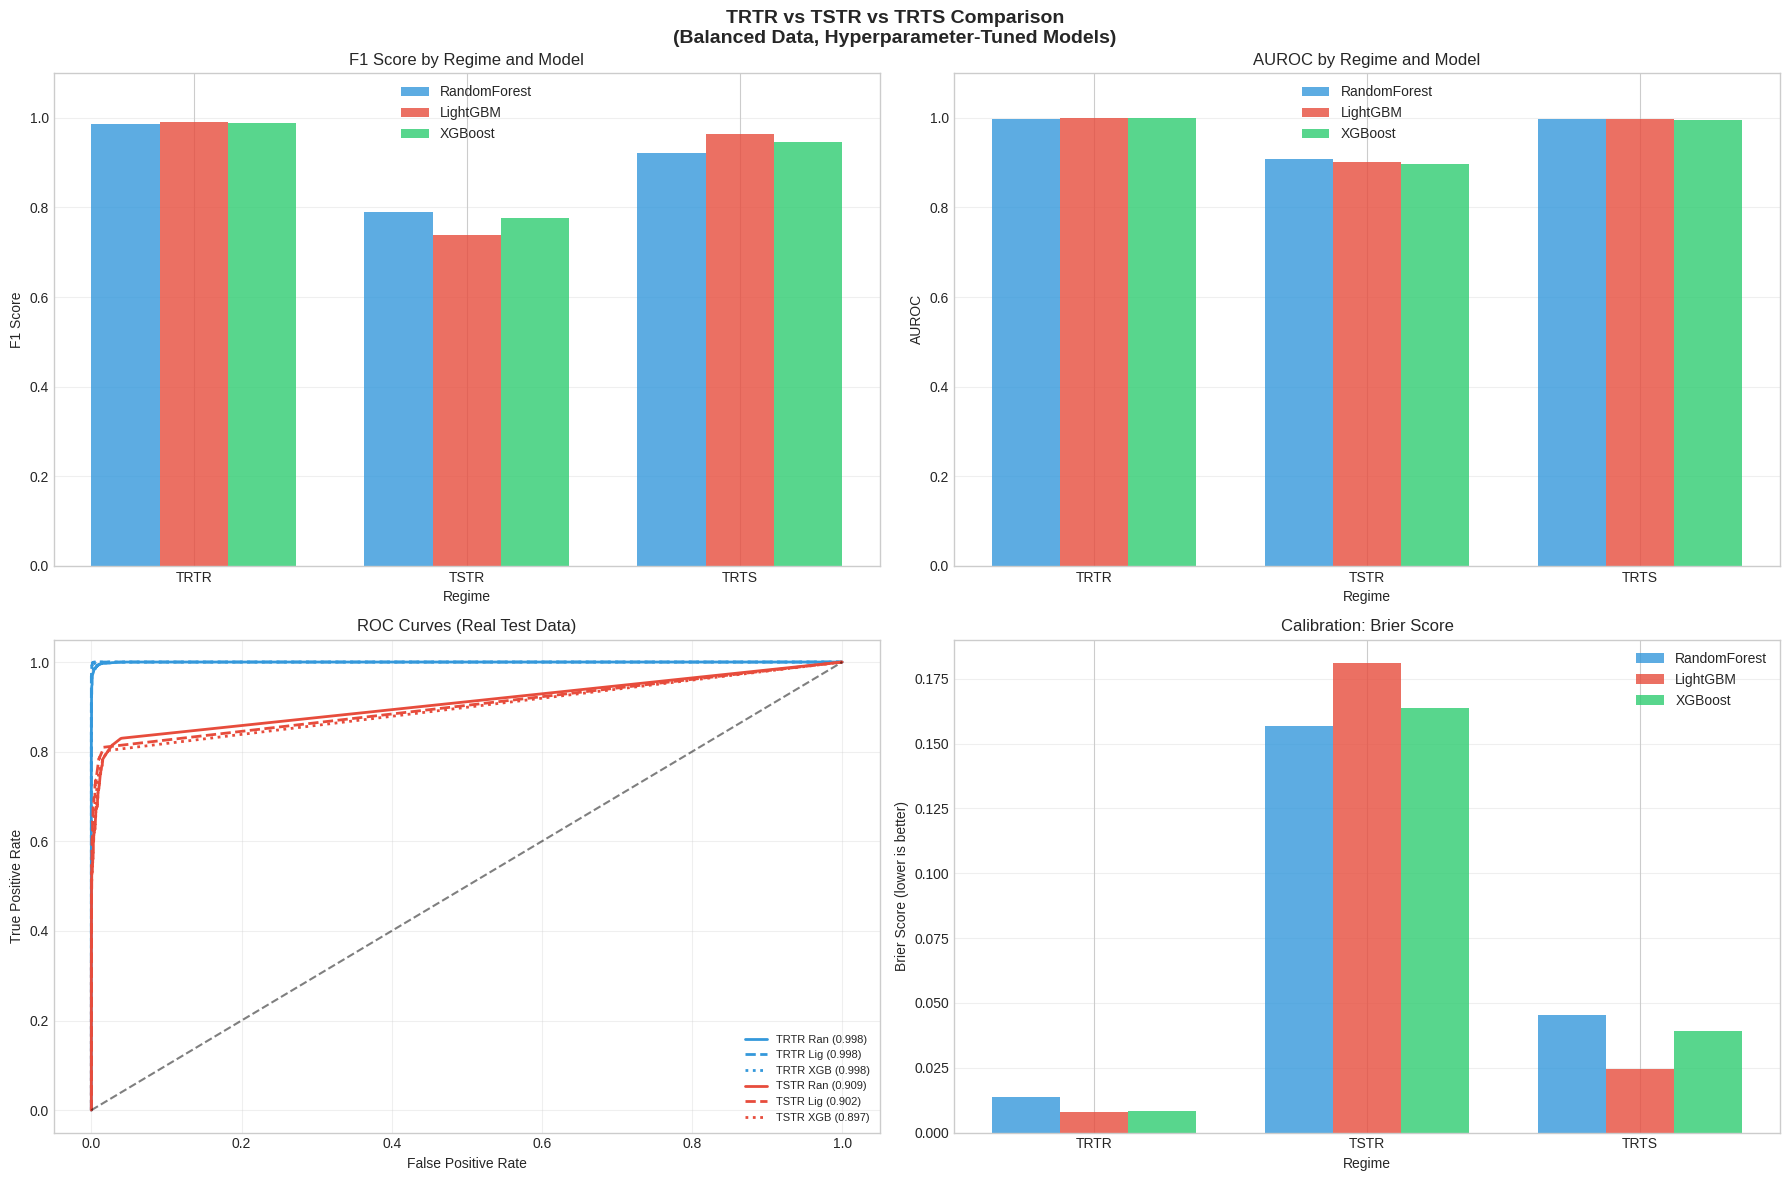

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/comparison_plot.png


In [200]:
# Main Comparison Plot
fig = plt.figure(figsize=(18, 12))

# 1. Bar chart of F1 scores
ax1 = fig.add_subplot(2, 2, 1)
regimes = ['TRTR', 'TSTR', 'TRTS']
model_names = list(MODEL_CLASSES.keys())
x = np.arange(len(regimes))
width = 0.25

colors = ['#3498db', '#e74c3c', '#2ecc71']
for i, model_name in enumerate(model_names):
    values = [all_results[r][model_name]['f1_score'] for r in regimes]
    ax1.bar(x + i*width, values, width, label=model_name, color=colors[i], alpha=0.8)

ax1.set_xlabel('Regime')
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Score by Regime and Model')
ax1.set_xticks(x + width)
ax1.set_xticklabels(regimes)
ax1.legend()
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# 2. AUROC comparison
ax2 = fig.add_subplot(2, 2, 2)
for i, model_name in enumerate(model_names):
    values = [all_results[r][model_name]['auroc'] for r in regimes]
    ax2.bar(x + i*width, values, width, label=model_name, color=colors[i], alpha=0.8)

ax2.set_xlabel('Regime')
ax2.set_ylabel('AUROC')
ax2.set_title('AUROC by Regime and Model')
ax2.set_xticks(x + width)
ax2.set_xticklabels(regimes)
ax2.legend()
ax2.set_ylim(0, 1.1)
ax2.grid(axis='y', alpha=0.3)

# 3. ROC Curves (TRTR and TSTR on real test data)
ax3 = fig.add_subplot(2, 2, 3)
line_styles = ['-', '--', ':']
regime_colors = {'TRTR': '#3498db', 'TSTR': '#e74c3c'}

for regime in ['TRTR', 'TSTR']:
    for i, model_name in enumerate(model_names):
        model = all_models[regime][model_name]
        y_prob = model.predict_proba(X_test_real_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_real, y_prob)
        auc = all_results[regime][model_name]['auroc']
        ax3.plot(fpr, tpr, linestyle=line_styles[i], color=regime_colors[regime],
                label=f'{regime} {model_name[:3]} ({auc:.3f})', linewidth=2)

ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves (Real Test Data)')
ax3.legend(loc='lower right', fontsize=8)
ax3.grid(alpha=0.3)

# 4. Brier Score (calibration)
ax4 = fig.add_subplot(2, 2, 4)
for i, model_name in enumerate(model_names):
    values = [all_results[r][model_name]['brier_score'] for r in regimes]
    ax4.bar(x + i*width, values, width, label=model_name, color=colors[i], alpha=0.8)

ax4.set_xlabel('Regime')
ax4.set_ylabel('Brier Score (lower is better)')
ax4.set_title('Calibration: Brier Score')
ax4.set_xticks(x + width)
ax4.set_xticklabels(regimes)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('TRTR vs TSTR vs TRTS Comparison\n(Balanced Data, Hyperparameter-Tuned Models)',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/comparison_plot.png", dpi=150, bbox_inches='tight')
plt.savefig(f"{OUTPUT_DIR}/comparison_plot.pdf", dpi=150, bbox_inches='tight')

plt.show()
print(f"Saved: {OUTPUT_DIR}/comparison_plot.png")

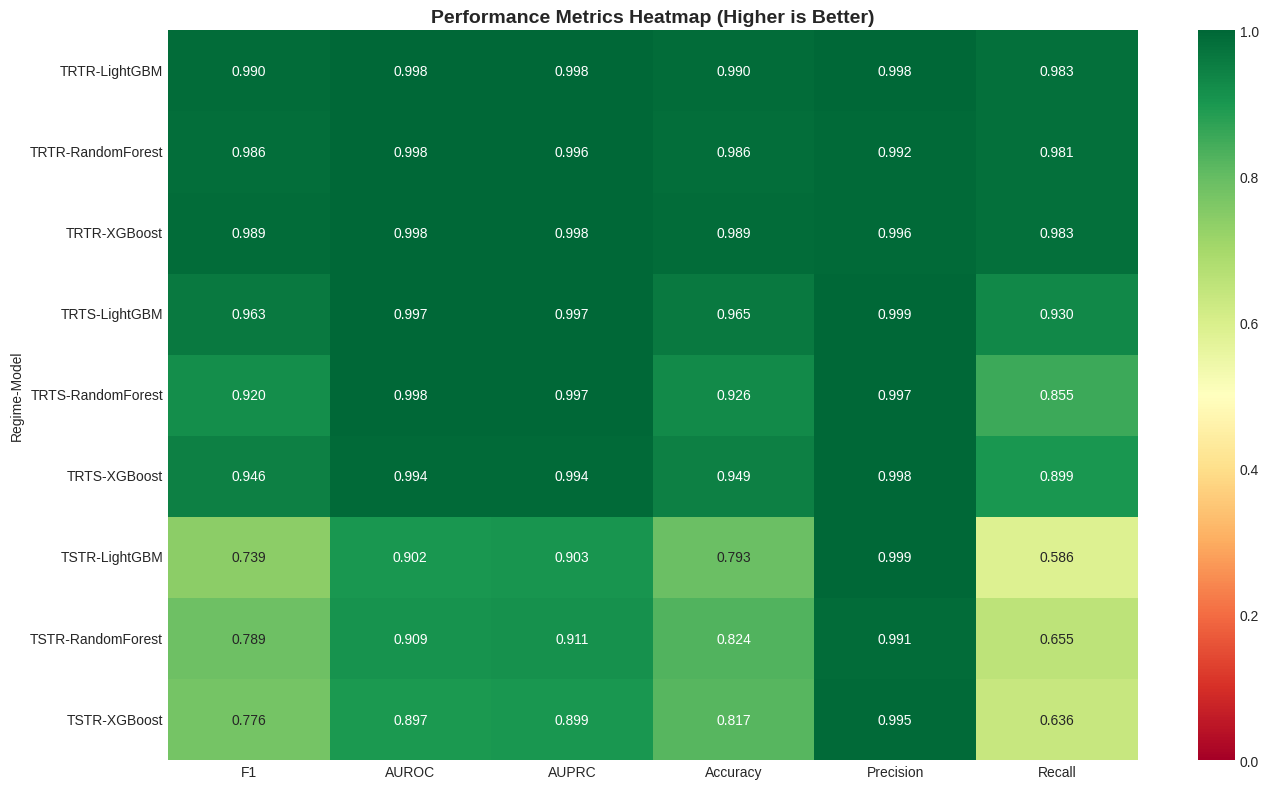

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/metrics_heatmap.png


In [201]:
# Heatmap of all metrics
fig, ax = plt.subplots(figsize=(14, 8))

metrics_for_heatmap = ['F1', 'AUROC', 'AUPRC', 'Accuracy', 'Precision', 'Recall']
heatmap_data = comparison_df.pivot_table(
    index=['Regime', 'Model'], 
    values=metrics_for_heatmap
)[metrics_for_heatmap]

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0.5, vmin=0, vmax=1, ax=ax)
ax.set_title('Performance Metrics Heatmap (Higher is Better)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/metrics_heatmap.png", dpi=150, bbox_inches='tight')
plt.savefig(f"{OUTPUT_DIR}/metrics_heatmap.pdf", dpi=150, bbox_inches='tight')

plt.show()
print(f"Saved: {OUTPUT_DIR}/metrics_heatmap.png")

---
## 10.1 Feature Analysis During Anomaly Detection


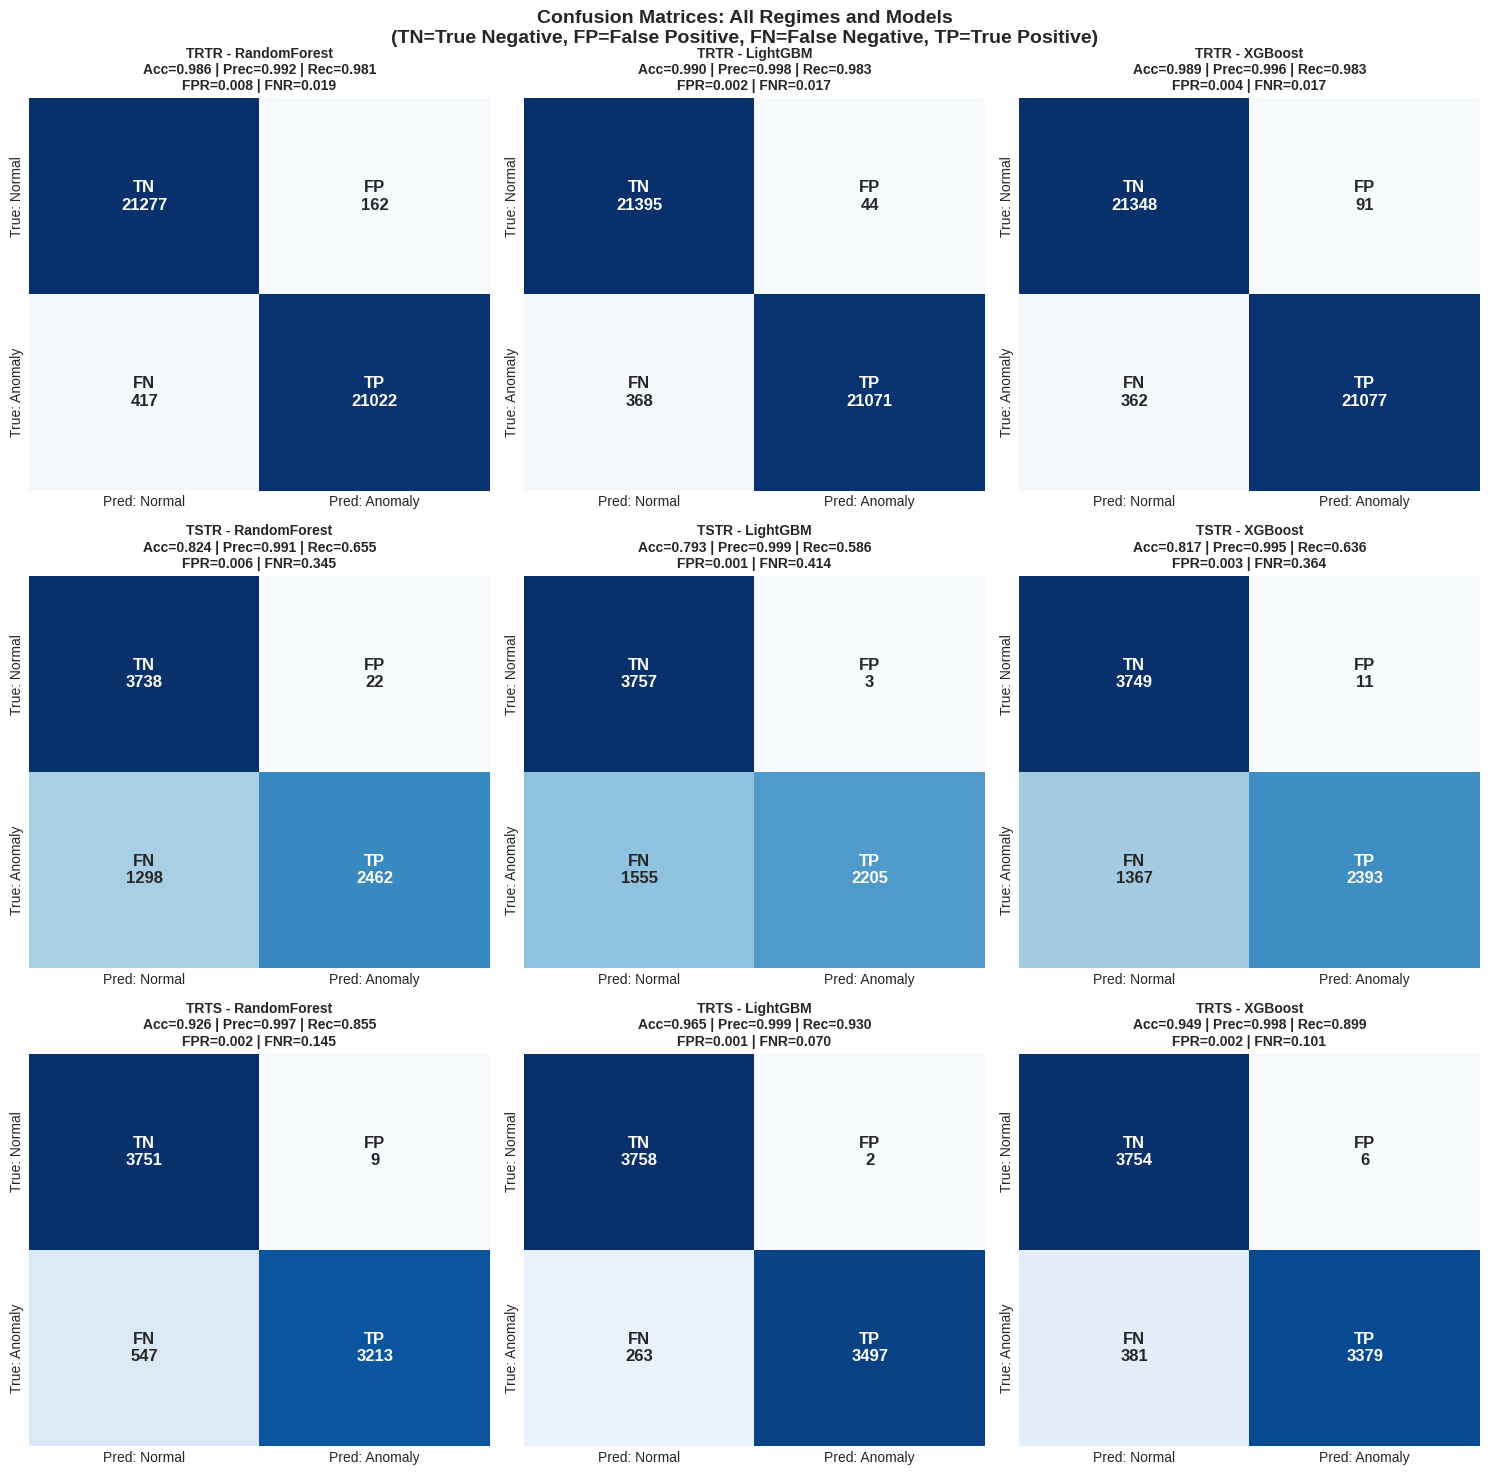

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/confusion_matrices.png

CONFUSION MATRIX SUMMARY
Regime   Model              TN       FP       FN       TP      FPR      FNR   Accuracy
------------------------------------------------------------------------------------------
TRTR     RandomForest    21277      162      417    21022   0.0076   0.0195     0.9865
TRTR     LightGBM        21395       44      368    21071   0.0021   0.0172     0.9904
TRTR     XGBoost         21348       91      362    21077   0.0042   0.0169     0.9894
TSTR     RandomForest     3738       22     1298     2462   0.0059   0.3452     0.8245
TSTR     LightGBM         3757        3     1555     2205   0.0008   0.4136     0.7928
TSTR     XGBoost          3749       11     1367     2393   0.0029   0.3636     0.8168
TRTS     RandomForest     3751        9      547     3213   0.0024   0.1455     0.9261
TRTS     LightGBM         3758        2      263     3497   0.0005   0.0699     0.9648
TRT

In [202]:
# ========================================
# CONFUSION MATRIX: TP, TN, FP, FN for All Models
# ========================================



# Create figure with subplots for each regime and model
n_regimes = 3
n_models = len(MODEL_CLASSES)

fig, axes = plt.subplots(n_regimes, n_models, figsize=(5*n_models, 5*n_regimes))

regimes = ['TRTR', 'TSTR', 'TRTS']
model_names = list(MODEL_CLASSES.keys())

for i, regime in enumerate(regimes):
    for j, model_name in enumerate(model_names):
        ax = axes[i, j] if n_models > 1 else axes[i]
        
        # Get confusion matrix from stored results
        cm = all_results[regime][model_name]['confusion_matrix']
        
        # Extract TP, TN, FP, FN
        TN, FP, FN, TP = cm.ravel()
        
        # Create annotated confusion matrix
        cm_labels = np.array([[f'TN\n{TN}', f'FP\n{FP}'],
                              [f'FN\n{FN}', f'TP\n{TP}']])
        
        # Plot heatmap
        sns.heatmap(cm, annot=cm_labels, fmt='', cmap='Blues', 
                    xticklabels=['Pred: Normal', 'Pred: Anomaly'],
                    yticklabels=['True: Normal', 'True: Anomaly'],
                    ax=ax, cbar=False, annot_kws={'size': 12, 'fontweight': 'bold'})
        
        # Calculate rates
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
        fnr = FN / (FN + TP) if (FN + TP) > 0 else 0  # False Negative Rate
        
        ax.set_title(f'{regime} - {model_name}\nAcc={accuracy:.3f} | Prec={precision:.3f} | Rec={recall:.3f}\nFPR={fpr:.3f} | FNR={fnr:.3f}', 
                     fontsize=10, fontweight='bold')

plt.suptitle('Confusion Matrices: All Regimes and Models\n(TN=True Negative, FP=False Positive, FN=False Negative, TP=True Positive)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion_matrices.png", dpi=150, bbox_inches='tight')
plt.savefig(f"{OUTPUT_DIR}/confusion_matrices.pdf", dpi=150, bbox_inches='tight')

plt.show()
print(f"Saved: {OUTPUT_DIR}/confusion_matrices.png")

# ========================================
# Summary Table: TP, TN, FP, FN for All Models
# ========================================
print("\n" + "="*90)
print("CONFUSION MATRIX SUMMARY")
print("="*90)
print(f"{'Regime':<8} {'Model':<12} {'TN':>8} {'FP':>8} {'FN':>8} {'TP':>8} {'FPR':>8} {'FNR':>8} {'Accuracy':>10}")
print("-"*90)

cm_summary = []
for regime in regimes:
    for model_name in model_names:
        cm = all_results[regime][model_name]['confusion_matrix']
        TN, FP, FN, TP = cm.ravel()
        
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        
        print(f"{regime:<8} {model_name:<12} {TN:>8} {FP:>8} {FN:>8} {TP:>8} {fpr:>8.4f} {fnr:>8.4f} {accuracy:>10.4f}")
        
        cm_summary.append({
            'Regime': regime,
            'Model': model_name,
            'TN': TN,
            'FP': FP,
            'FN': FN,
            'TP': TP,
            'FPR': fpr,
            'FNR': fnr,
            'Accuracy': accuracy
        })

# Save to CSV
cm_df = pd.DataFrame(cm_summary)
cm_df.to_csv(f"{OUTPUT_DIR}/confusion_matrix_summary.csv", index=False)
print(f"\nSaved: {OUTPUT_DIR}/confusion_matrix_summary.csv")


In [203]:
# ========================================
# FEATURE VISUALIZATION: Key Features for Anomaly Detection
# ========================================

# Features to visualize
VIZ_FEATURES = ['announcements', 'withdrawals', 'edit_distance_avg']

# Create dataframes with labels for visualization
df_real_viz = X_real.copy()
df_real_viz['label'] = y_real
df_real_viz['label_name'] = df_real_viz['label'].map({0: 'Normal', 1: 'Anomaly'})
df_real_viz['dataset'] = 'Real'

df_synth_viz = X_synthetic.copy()
df_synth_viz['label'] = y_synthetic
df_synth_viz['label_name'] = df_synth_viz['label'].map({0: 'Normal', 1: 'Anomaly'})
df_synth_viz['dataset'] = 'Synthetic'

# Combine for comparison
df_combined_viz = pd.concat([df_real_viz, df_synth_viz], ignore_index=True)

print("Feature Statistics:")
print("="*70)
for feature in VIZ_FEATURES:
    print(f"\n{feature.upper()}:")
    for dataset in ['Real', 'Synthetic']:
        subset = df_combined_viz[df_combined_viz['dataset'] == dataset]
        for label_name in ['Normal', 'Anomaly']:
            data = subset[subset['label_name'] == label_name][feature]
            print(f"  {dataset:10} {label_name:8}: mean={data.mean():10.2f}, std={data.std():10.2f}, "
                  f"median={data.median():10.2f}, max={data.max():12.2f}")

Feature Statistics:

ANNOUNCEMENTS:
  Real       Normal  : mean=    108.67, std=    170.18, median=     44.00, max=     1341.00
  Real       Anomaly : mean=    816.32, std=   4921.43, median=    113.00, max=   136167.00


  Synthetic  Normal  : mean=    106.99, std=    168.69, median=     42.00, max=     1119.00
  Synthetic  Anomaly : mean=    468.64, std=    997.38, median=    169.00, max=    22102.00

WITHDRAWALS:
  Real       Normal  : mean=      5.89, std=     12.89, median=      2.00, max=      239.00
  Real       Anomaly : mean=     47.81, std=    190.77, median=      3.00, max=     9527.00
  Synthetic  Normal  : mean=      4.93, std=      9.08, median=      2.00, max=      217.00
  Synthetic  Anomaly : mean=     26.04, std=     82.86, median=      4.00, max=     2105.00

EDIT_DISTANCE_AVG:
  Real       Normal  : mean=      1.80, std=      0.99, median=      1.76, max=       11.00
  Real       Anomaly : mean=      1.99, std=      2.18, median=      1.56, max=       36.50
  Synthetic  Normal  : mean=      1.77, std=      0.91, median=      1.75, max=       11.53
  Synthetic  Anomaly : mean=      2.29, std=      1.86, median=      1.95, max=       15.99


Loading data with timestamps...
Using timestamp column: 'window_start'
Normal data time range: 2025-11-16 00:05:01 to 2025-11-17 00:04:59
Anomaly data time range: 2003-08-11 16:00:26 to 2021-10-04 20:58:35


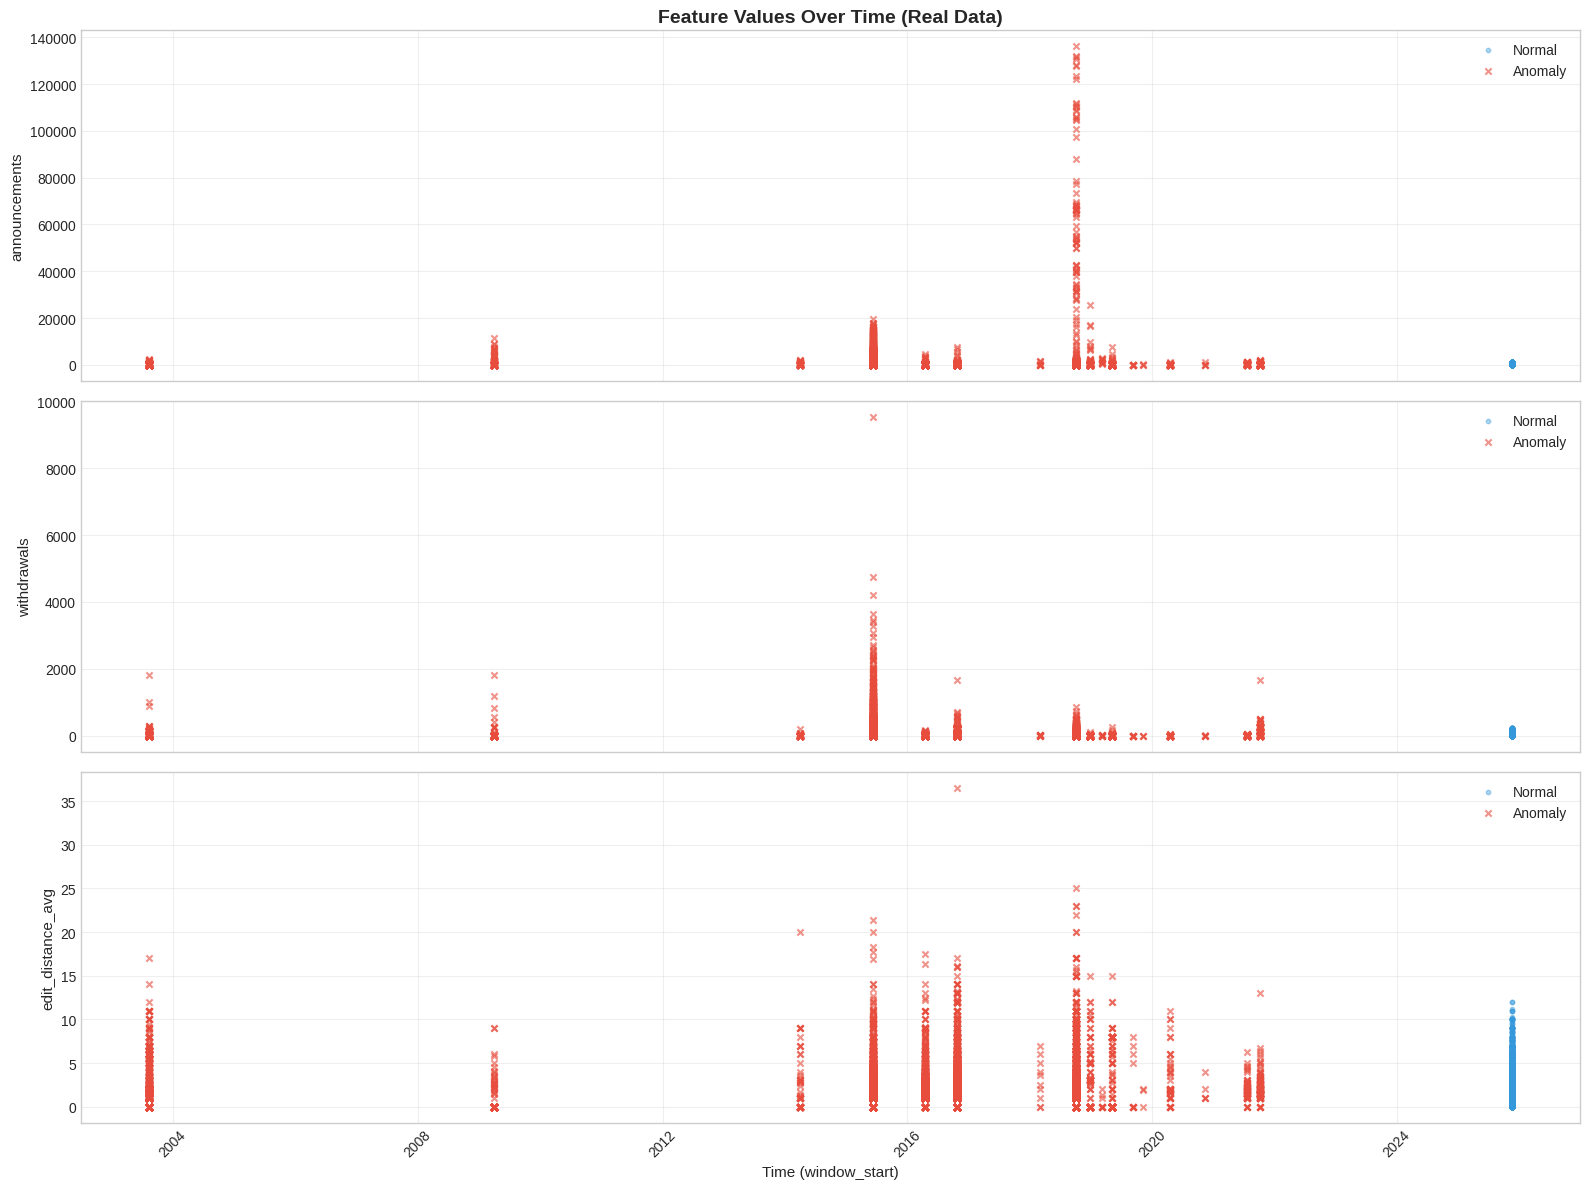

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/feature_timeseries.png
Data spans 8133 days, using Daily resampling


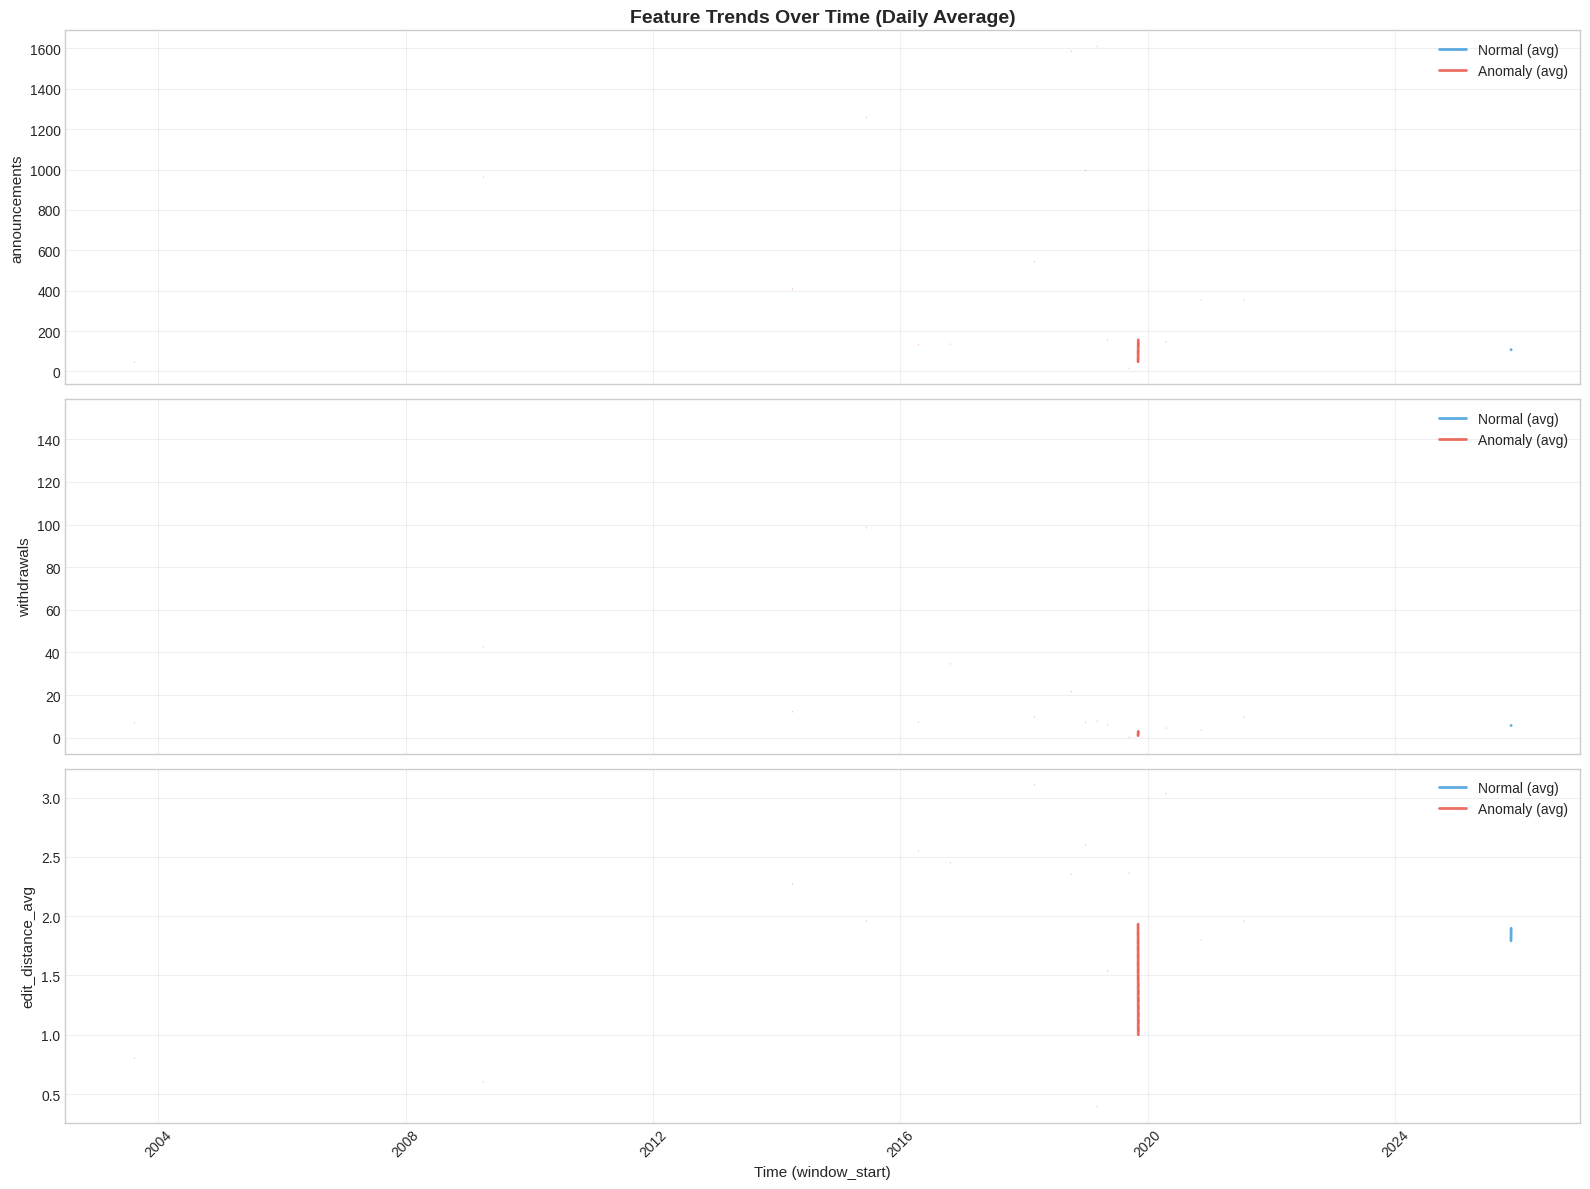

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/feature_trends.png


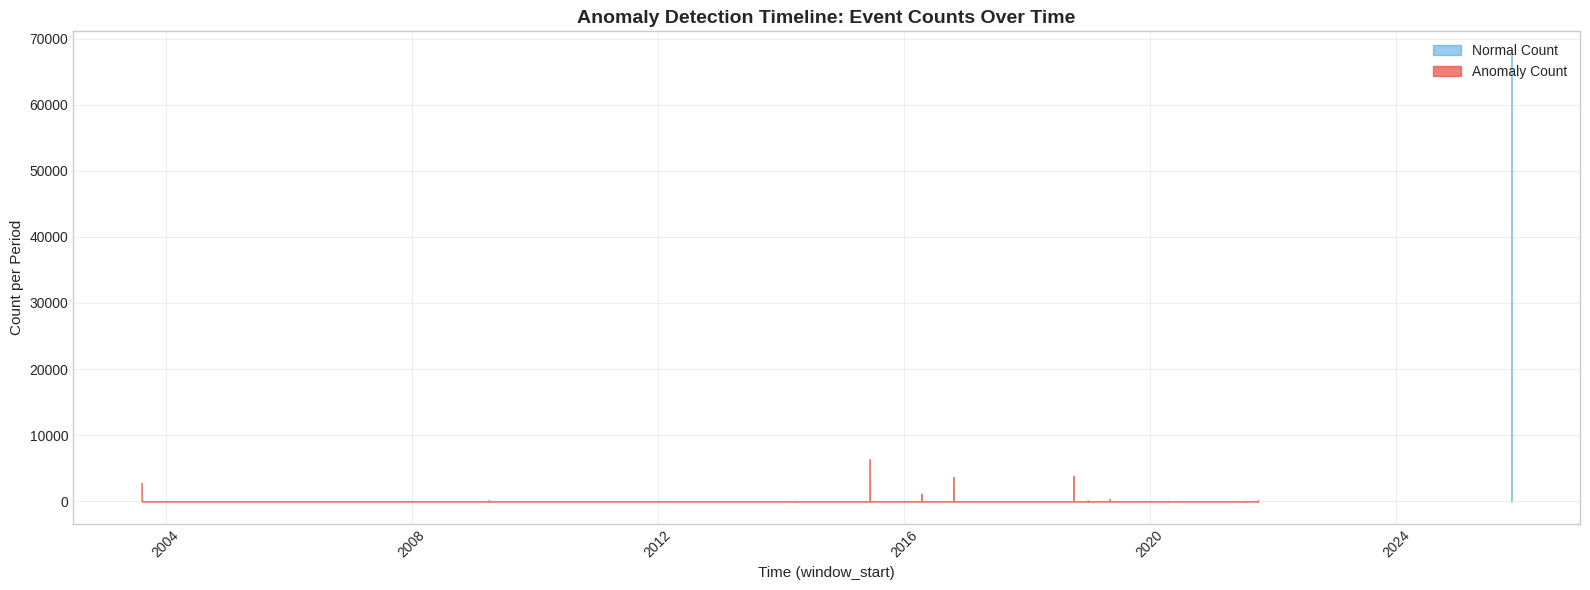

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/anomaly_timeline.png


In [204]:
# ========================================
# 6. TIME-SERIES VISUALIZATION: Features Over Time
# ========================================

# Reload original data with timestamps
print("Loading data with timestamps...")

# Real Normal with timestamp
df_real_normal_ts = pd.read_csv(REAL_NORMAL_PATH)
df_real_normal_ts = df_real_normal_ts[df_real_normal_ts[REAL_NORMAL_LABEL_COLUMN].isin(REAL_NORMAL_FILTER_VALUES)].copy()
df_real_normal_ts['label'] = 0
df_real_normal_ts['label_name'] = 'Normal'

# Real Anomaly with timestamp
df_real_anomaly_ts = pd.read_csv(REAL_ANOMALY_PATH)
df_real_anomaly_ts = df_real_anomaly_ts[df_real_anomaly_ts[REAL_ANOMALY_LABEL_COLUMN].isin(REAL_ANOMALY_FILTER_VALUES)].copy()
df_real_anomaly_ts['label'] = 1
df_real_anomaly_ts['label_name'] = 'Anomaly'

# Use window_start as timestamp
ts_col = 'window_start'
print(f"Using timestamp column: '{ts_col}'")

# Convert to datetime
df_real_normal_ts[ts_col] = pd.to_datetime(df_real_normal_ts[ts_col], errors='coerce')
df_real_anomaly_ts[ts_col] = pd.to_datetime(df_real_anomaly_ts[ts_col], errors='coerce')

# Sort by timestamp
df_real_normal_ts = df_real_normal_ts.sort_values(ts_col).reset_index(drop=True)
df_real_anomaly_ts = df_real_anomaly_ts.sort_values(ts_col).reset_index(drop=True)

print(f"Normal data time range: {df_real_normal_ts[ts_col].min()} to {df_real_normal_ts[ts_col].max()}")
print(f"Anomaly data time range: {df_real_anomaly_ts[ts_col].min()} to {df_real_anomaly_ts[ts_col].max()}")

# ========================================
# Plot 1: Time Series with Anomalies Highlighted
# ========================================
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

for i, feature in enumerate(VIZ_FEATURES):
    ax = axes[i]
    
    # Plot normal points (blue)
    ax.scatter(df_real_normal_ts[ts_col], df_real_normal_ts[feature], 
               c='#3498db', alpha=0.4, s=10, label='Normal')
    
    # Plot anomaly points (red)
    ax.scatter(df_real_anomaly_ts[ts_col], df_real_anomaly_ts[feature], 
               c='#e74c3c', alpha=0.6, s=20, marker='x', label='Anomaly')
    
    ax.set_ylabel(feature, fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    
    if i == 0:
        ax.set_title('Feature Values Over Time (Real Data)', fontsize=14, fontweight='bold')

axes[-1].set_xlabel('Time (window_start)', fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/feature_timeseries.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/feature_timeseries.png")

# ========================================
# Plot 2: Aggregated View (Hourly/Daily averages)
# ========================================
df_combined_ts = pd.concat([
    df_real_normal_ts[[ts_col] + VIZ_FEATURES + ['label', 'label_name']],
    df_real_anomaly_ts[[ts_col] + VIZ_FEATURES + ['label', 'label_name']]
], ignore_index=True)

df_combined_ts = df_combined_ts.dropna(subset=[ts_col])
df_combined_ts = df_combined_ts.set_index(ts_col).sort_index()

# Determine resampling frequency
time_range = (df_combined_ts.index.max() - df_combined_ts.index.min()).days
resample_freq = 'H' if time_range < 7 else 'D'
print(f"Data spans {time_range} days, using {'Hourly' if resample_freq == 'H' else 'Daily'} resampling")

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

for i, feature in enumerate(VIZ_FEATURES):
    ax = axes[i]
    
    for label_val, color, label_name in [(0, '#3498db', 'Normal'), (1, '#e74c3c', 'Anomaly')]:
        subset = df_combined_ts[df_combined_ts['label'] == label_val]
        if len(subset) > 0:
            resampled = subset[feature].resample(resample_freq).mean()
            ax.plot(resampled.index, resampled.values, color=color, 
                   label=f'{label_name} (avg)', linewidth=2, alpha=0.8)
            
            if len(resampled) > 5:
                rolling = resampled.rolling(window=5, min_periods=1).mean()
                ax.plot(rolling.index, rolling.values, color=color, 
                       linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_ylabel(feature, fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    
    if i == 0:
        ax.set_title(f'Feature Trends Over Time ({"Hourly" if resample_freq == "H" else "Daily"} Average)', 
                    fontsize=14, fontweight='bold')

axes[-1].set_xlabel('Time (window_start)', fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/feature_trends.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/feature_trends.png")

# ========================================
# Plot 3: Anomaly Detection Timeline
# ========================================
fig, ax = plt.subplots(figsize=(16, 6))

anomaly_counts = df_real_anomaly_ts.set_index(ts_col).resample(resample_freq).size()
normal_counts = df_real_normal_ts.set_index(ts_col).resample(resample_freq).size()

ax.fill_between(normal_counts.index, 0, normal_counts.values, 
                alpha=0.5, color='#3498db', label='Normal Count')
ax.fill_between(anomaly_counts.index, 0, anomaly_counts.values, 
                alpha=0.7, color='#e74c3c', label='Anomaly Count')

ax.set_xlabel('Time (window_start)', fontsize=11)
ax.set_ylabel('Count per Period', fontsize=11)
ax.set_title('Anomaly Detection Timeline: Event Counts Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/anomaly_timeline.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/anomaly_timeline.png")


Loading synthetic data with timestamps...
Synthetic Normal columns: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'nadas', 'flaps', 'edit_distance_avg', 'rare_ases_avg', 'timestamp', 'label', 'discovered_label', 'generation_method', 'log_transform_used', 'bgp_constraints_enforced', 'label_name']
Synthetic Anomaly columns: ['timestamp', 'announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2

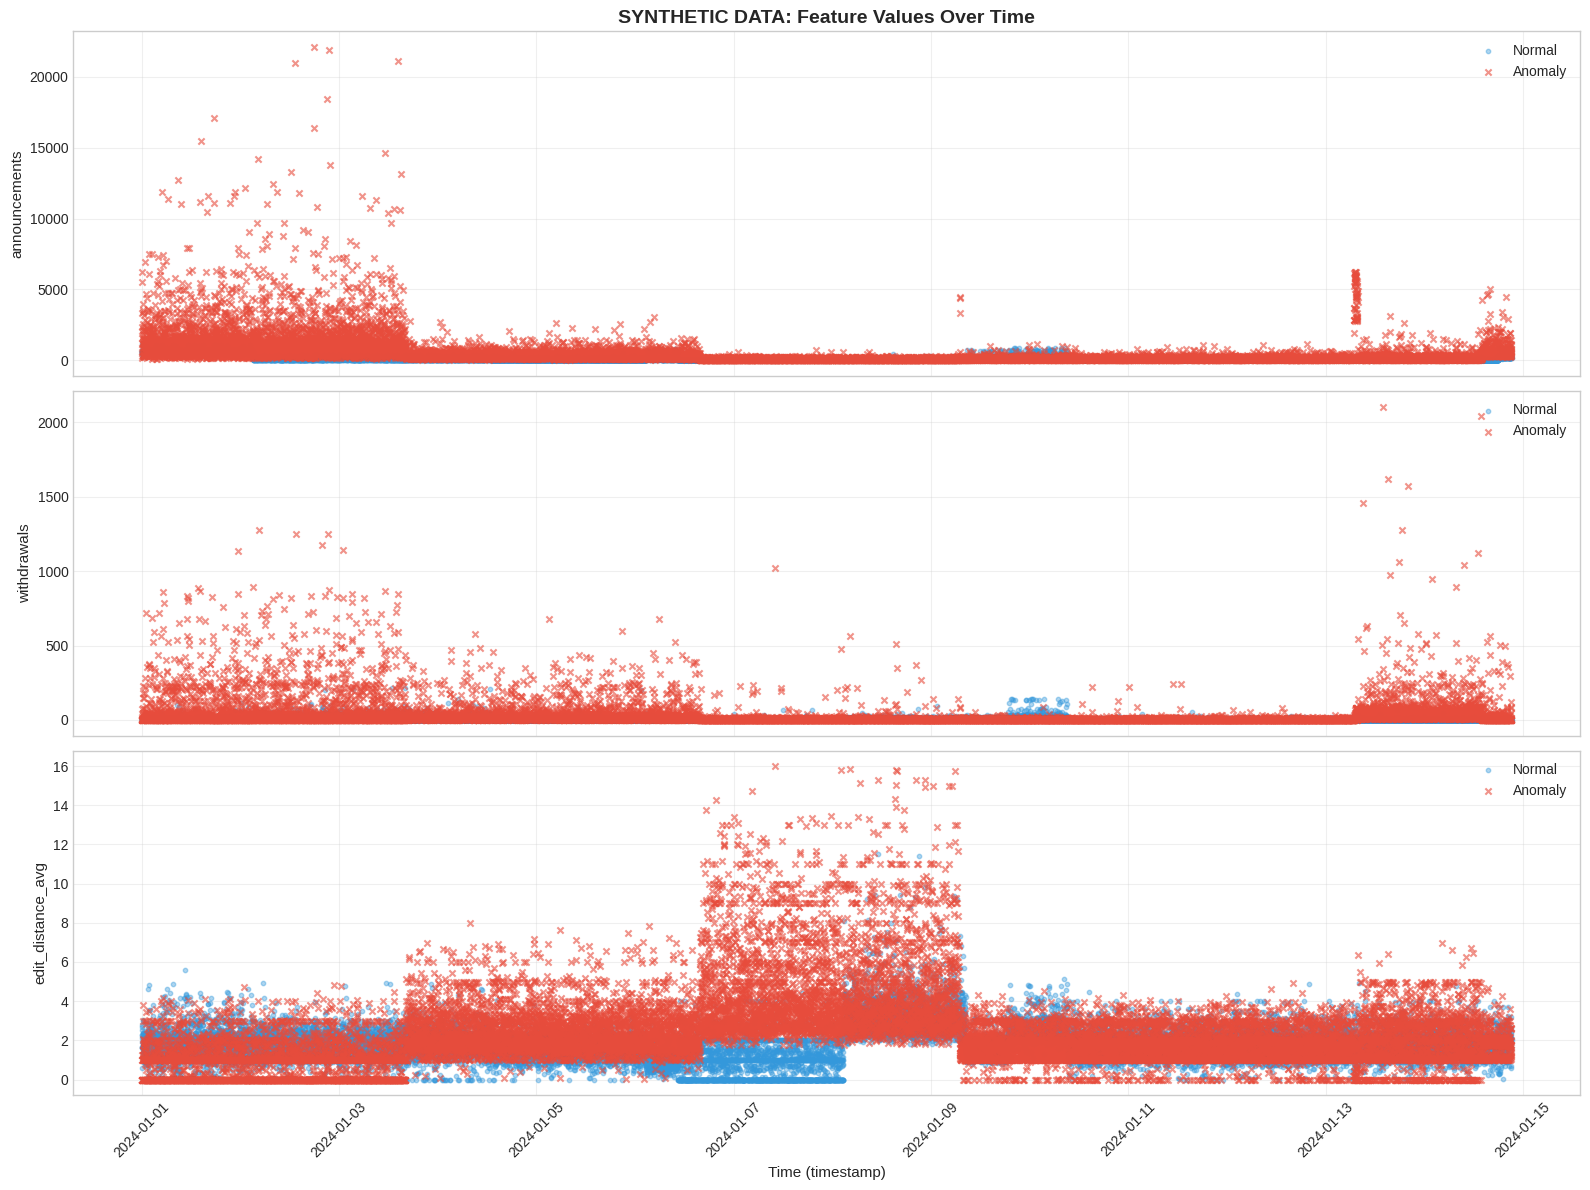

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/synthetic_feature_timeseries.png
Synthetic data spans 13 days, using Daily resampling


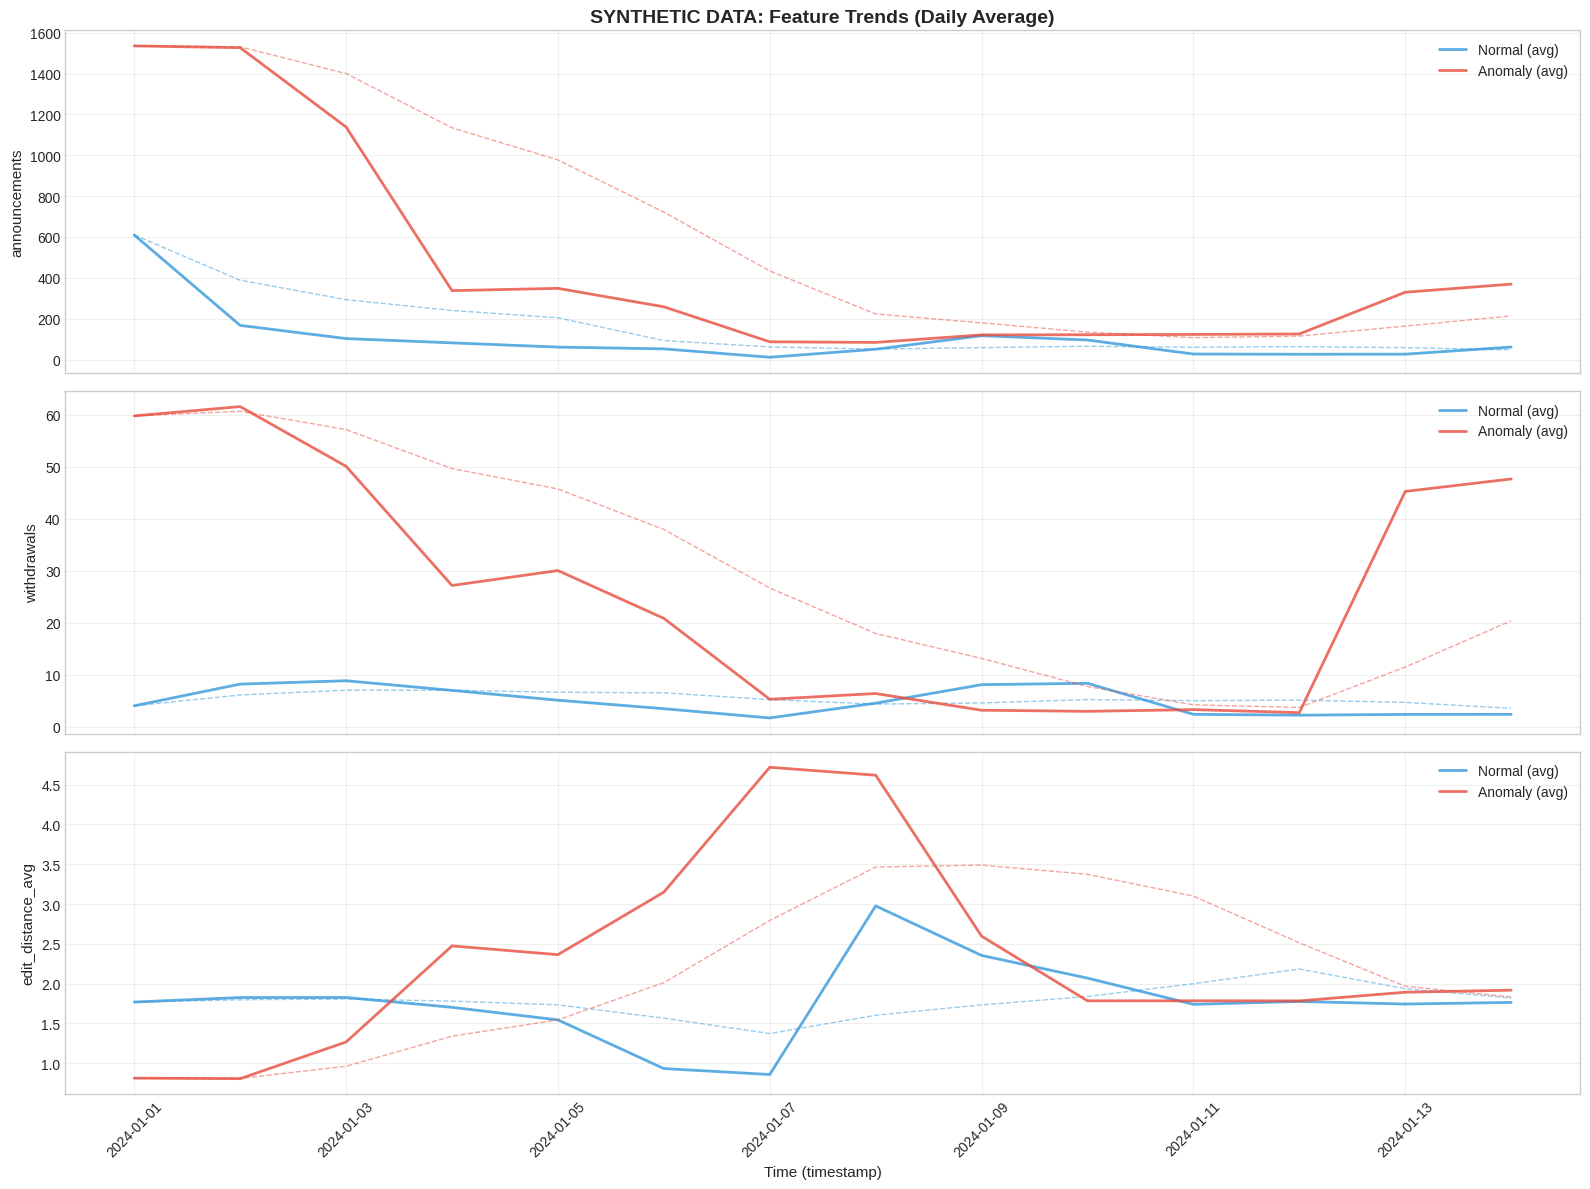

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/synthetic_feature_trends.png


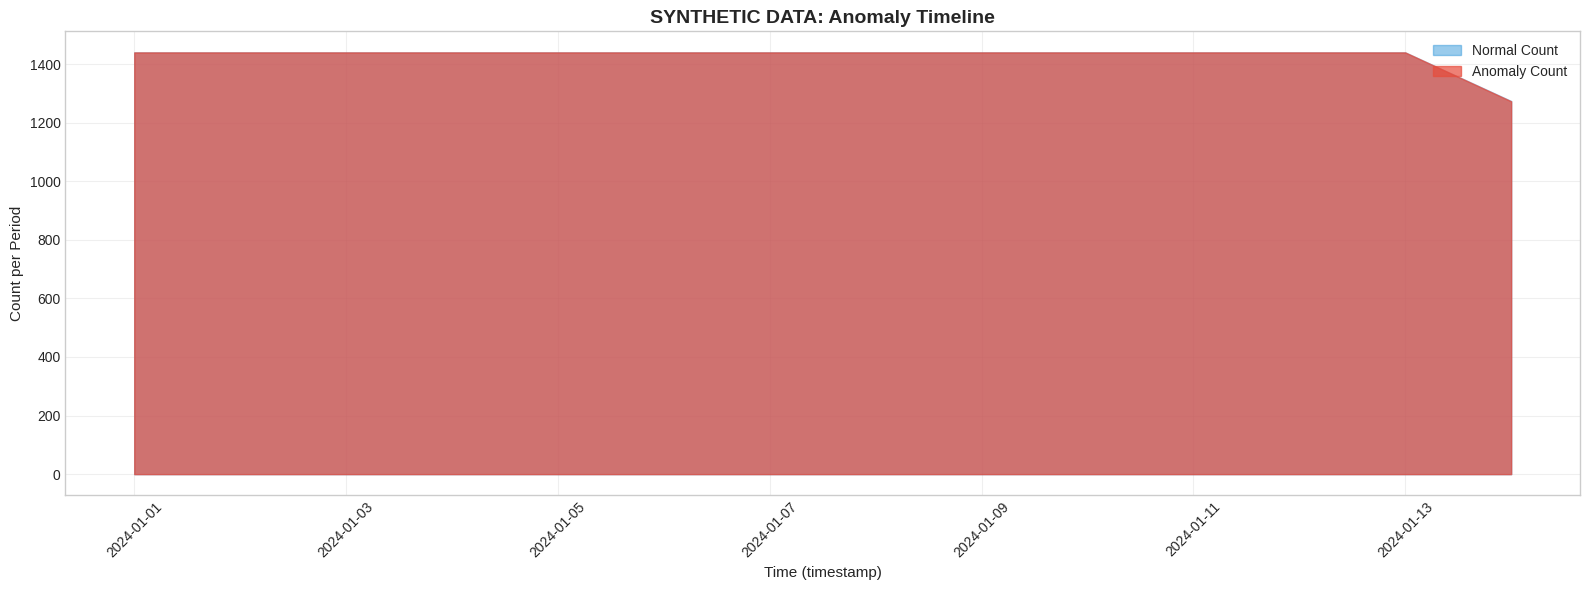

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/synthetic_anomaly_timeline.png


In [205]:
# ========================================
# 7. TIME-SERIES VISUALIZATION: Synthetic Data
# ========================================

# Load synthetic data with timestamps
print("Loading synthetic data with timestamps...")

df_synth_normal_ts = pd.read_csv(SYNTHETIC_NORMAL_PATH)
df_synth_normal_ts['label'] = 0
df_synth_normal_ts['label_name'] = 'Normal'

df_synth_anomaly_ts = pd.read_csv(SYNTHETIC_ANOMALY_PATH)
df_synth_anomaly_ts['label'] = 1
df_synth_anomaly_ts['label_name'] = 'Anomaly'

# Check available columns for timestamp
print(f"Synthetic Normal columns: {df_synth_normal_ts.columns.tolist()}")
print(f"Synthetic Anomaly columns: {df_synth_anomaly_ts.columns.tolist()}")

# Find timestamp column (adjust if needed)
ts_candidates = ['timestamp', 'window_start', 'time', 'start_time', 'sequence_id']
ts_col_synth = None
for col in ts_candidates:
    if col in df_synth_normal_ts.columns:
        ts_col_synth = col
        break

if ts_col_synth is None:
    print("No timestamp column found. Using index as time proxy.")
    df_synth_normal_ts['time_index'] = range(len(df_synth_normal_ts))
    df_synth_anomaly_ts['time_index'] = range(len(df_synth_anomaly_ts))
    ts_col_synth = 'time_index'
    use_datetime = False
else:
    print(f"Using timestamp column: '{ts_col_synth}'")
    # Try to convert to datetime
    try:
        df_synth_normal_ts[ts_col_synth] = pd.to_datetime(df_synth_normal_ts[ts_col_synth], errors='coerce')
        df_synth_anomaly_ts[ts_col_synth] = pd.to_datetime(df_synth_anomaly_ts[ts_col_synth], errors='coerce')
        use_datetime = True
    except:
        use_datetime = False
        print(f"Could not convert to datetime, using as-is")

# Sort by timestamp
df_synth_normal_ts = df_synth_normal_ts.sort_values(ts_col_synth).reset_index(drop=True)
df_synth_anomaly_ts = df_synth_anomaly_ts.sort_values(ts_col_synth).reset_index(drop=True)

print(f"Synthetic Normal: {len(df_synth_normal_ts)} samples")
print(f"Synthetic Anomaly: {len(df_synth_anomaly_ts)} samples")

# ========================================
# Plot 1: Synthetic Time Series with Anomalies Highlighted
# ========================================
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

for i, feature in enumerate(VIZ_FEATURES):
    ax = axes[i]
    
    # Plot normal points (blue)
    ax.scatter(df_synth_normal_ts[ts_col_synth], df_synth_normal_ts[feature], 
               c='#3498db', alpha=0.4, s=10, label='Normal')
    
    # Plot anomaly points (red)
    ax.scatter(df_synth_anomaly_ts[ts_col_synth], df_synth_anomaly_ts[feature], 
               c='#e74c3c', alpha=0.6, s=20, marker='x', label='Anomaly')
    
    ax.set_ylabel(feature, fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    
    if i == 0:
        ax.set_title('SYNTHETIC DATA: Feature Values Over Time', fontsize=14, fontweight='bold')

axes[-1].set_xlabel(f'Time ({ts_col_synth})', fontsize=11)
if use_datetime:
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/synthetic_feature_timeseries.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/synthetic_feature_timeseries.png")

# ========================================
# Plot 2: Synthetic Aggregated View
# ========================================
if use_datetime:
    df_synth_combined_ts = pd.concat([
        df_synth_normal_ts[[ts_col_synth] + VIZ_FEATURES + ['label', 'label_name']],
        df_synth_anomaly_ts[[ts_col_synth] + VIZ_FEATURES + ['label', 'label_name']]
    ], ignore_index=True)
    
    df_synth_combined_ts = df_synth_combined_ts.dropna(subset=[ts_col_synth])
    df_synth_combined_ts = df_synth_combined_ts.set_index(ts_col_synth).sort_index()
    
    time_range = (df_synth_combined_ts.index.max() - df_synth_combined_ts.index.min()).days
    resample_freq = 'H' if time_range < 7 else 'D'
    print(f"Synthetic data spans {time_range} days, using {'Hourly' if resample_freq == 'H' else 'Daily'} resampling")
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
    
    for i, feature in enumerate(VIZ_FEATURES):
        ax = axes[i]
        
        for label_val, color, label_name in [(0, '#3498db', 'Normal'), (1, '#e74c3c', 'Anomaly')]:
            subset = df_synth_combined_ts[df_synth_combined_ts['label'] == label_val]
            if len(subset) > 0:
                resampled = subset[feature].resample(resample_freq).mean()
                ax.plot(resampled.index, resampled.values, color=color, 
                       label=f'{label_name} (avg)', linewidth=2, alpha=0.8)
                
                if len(resampled) > 5:
                    rolling = resampled.rolling(window=5, min_periods=1).mean()
                    ax.plot(rolling.index, rolling.values, color=color, 
                           linestyle='--', linewidth=1, alpha=0.5)
        
        ax.set_ylabel(feature, fontsize=11)
        ax.legend(loc='upper right')
        ax.grid(alpha=0.3)
        
        if i == 0:
            ax.set_title(f'SYNTHETIC DATA: Feature Trends ({"Hourly" if resample_freq == "H" else "Daily"} Average)', 
                        fontsize=14, fontweight='bold')
    
    axes[-1].set_xlabel(f'Time ({ts_col_synth})', fontsize=11)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/synthetic_feature_trends.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/synthetic_feature_trends.png")
    
    # ========================================
    # Plot 3: Synthetic Anomaly Timeline
    # ========================================
    fig, ax = plt.subplots(figsize=(16, 6))
    
    anomaly_counts = df_synth_anomaly_ts.set_index(ts_col_synth).resample(resample_freq).size()
    normal_counts = df_synth_normal_ts.set_index(ts_col_synth).resample(resample_freq).size()
    
    ax.fill_between(normal_counts.index, 0, normal_counts.values, 
                    alpha=0.5, color='#3498db', label='Normal Count')
    ax.fill_between(anomaly_counts.index, 0, anomaly_counts.values, 
                    alpha=0.7, color='#e74c3c', label='Anomaly Count')
    
    ax.set_xlabel(f'Time ({ts_col_synth})', fontsize=11)
    ax.set_ylabel('Count per Period', fontsize=11)
    ax.set_title('SYNTHETIC DATA: Anomaly Timeline', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/synthetic_anomaly_timeline.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/synthetic_anomaly_timeline.png")

else:
    # If no datetime, use rolling window visualization instead
    print("Using index-based visualization (no datetime)")
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    for i, feature in enumerate(VIZ_FEATURES):
        ax = axes[i]
        
        # Rolling mean for normal
        normal_rolling = df_synth_normal_ts[feature].rolling(window=50, min_periods=1).mean()
        ax.plot(range(len(normal_rolling)), normal_rolling, color='#3498db', 
               label='Normal (rolling avg)', linewidth=2, alpha=0.8)
        
        # Rolling mean for anomaly
        anomaly_rolling = df_synth_anomaly_ts[feature].rolling(window=50, min_periods=1).mean()
        ax.plot(range(len(anomaly_rolling)), anomaly_rolling, color='#e74c3c', 
               label='Anomaly (rolling avg)', linewidth=2, alpha=0.8)
        
        ax.set_ylabel(feature, fontsize=11)
        ax.legend(loc='upper right')
        ax.grid(alpha=0.3)
        
        if i == 0:
            ax.set_title('SYNTHETIC DATA: Feature Rolling Average (window=50)', fontsize=14, fontweight='bold')
    
    axes[-1].set_xlabel('Sample Index', fontsize=11)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/synthetic_feature_rolling.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/synthetic_feature_rolling.png")


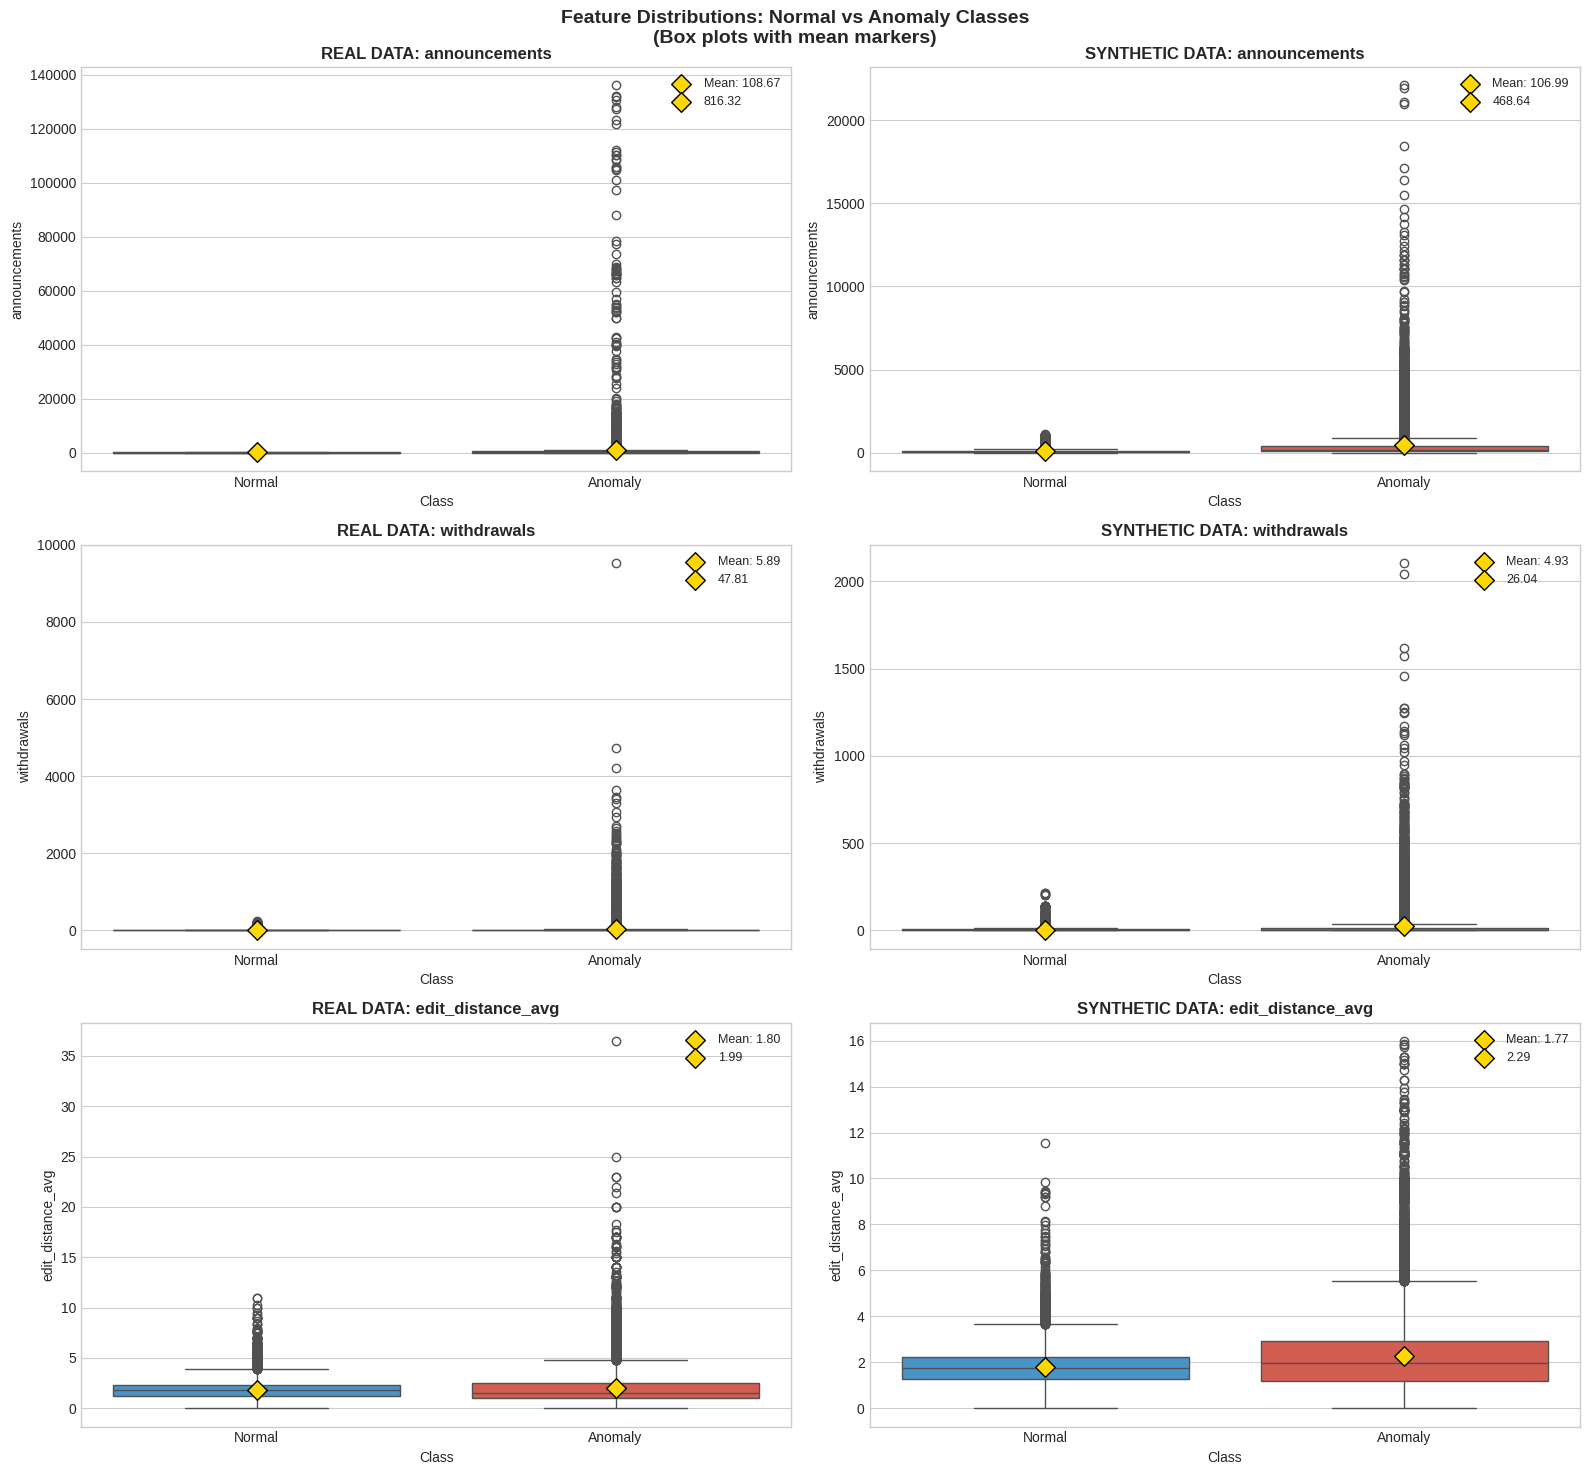

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/feature_boxplots.png


In [206]:
# ========================================
# 1. BOX PLOTS: Feature Distributions by Class (Real vs Synthetic)
# ========================================

fig, axes = plt.subplots(len(VIZ_FEATURES), 2, figsize=(16, 5*len(VIZ_FEATURES)))

for i, feature in enumerate(VIZ_FEATURES):
    # Real data
    ax1 = axes[i, 0]
    real_data = df_real_viz[[feature, 'label_name']]
    sns.boxplot(data=real_data, x='label_name', y=feature, ax=ax1, 
                palette={'Normal': '#3498db', 'Anomaly': '#e74c3c'})
    ax1.set_title(f'REAL DATA: {feature}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Class')
    ax1.set_ylabel(feature)
    
    # Add mean markers
    means = real_data.groupby('label_name')[feature].mean()
    for j, label in enumerate(['Normal', 'Anomaly']):
        if label in means.index:
            ax1.scatter(j, means[label], color='gold', s=100, marker='D', zorder=5, 
                       edgecolors='black', label=f'Mean: {means[label]:.2f}' if j == 0 else f'{means[label]:.2f}')
    ax1.legend(loc='upper right', fontsize=9)
    
    # Synthetic data
    ax2 = axes[i, 1]
    synth_data = df_synth_viz[[feature, 'label_name']]
    sns.boxplot(data=synth_data, x='label_name', y=feature, ax=ax2,
                palette={'Normal': '#3498db', 'Anomaly': '#e74c3c'})
    ax2.set_title(f'SYNTHETIC DATA: {feature}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Class')
    ax2.set_ylabel(feature)
    
    # Add mean markers
    means = synth_data.groupby('label_name')[feature].mean()
    for j, label in enumerate(['Normal', 'Anomaly']):
        if label in means.index:
            ax2.scatter(j, means[label], color='gold', s=100, marker='D', zorder=5,
                       edgecolors='black', label=f'Mean: {means[label]:.2f}' if j == 0 else f'{means[label]:.2f}')
    ax2.legend(loc='upper right', fontsize=9)

plt.suptitle('Feature Distributions: Normal vs Anomaly Classes\n(Box plots with mean markers)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/feature_boxplots.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/feature_boxplots.png")

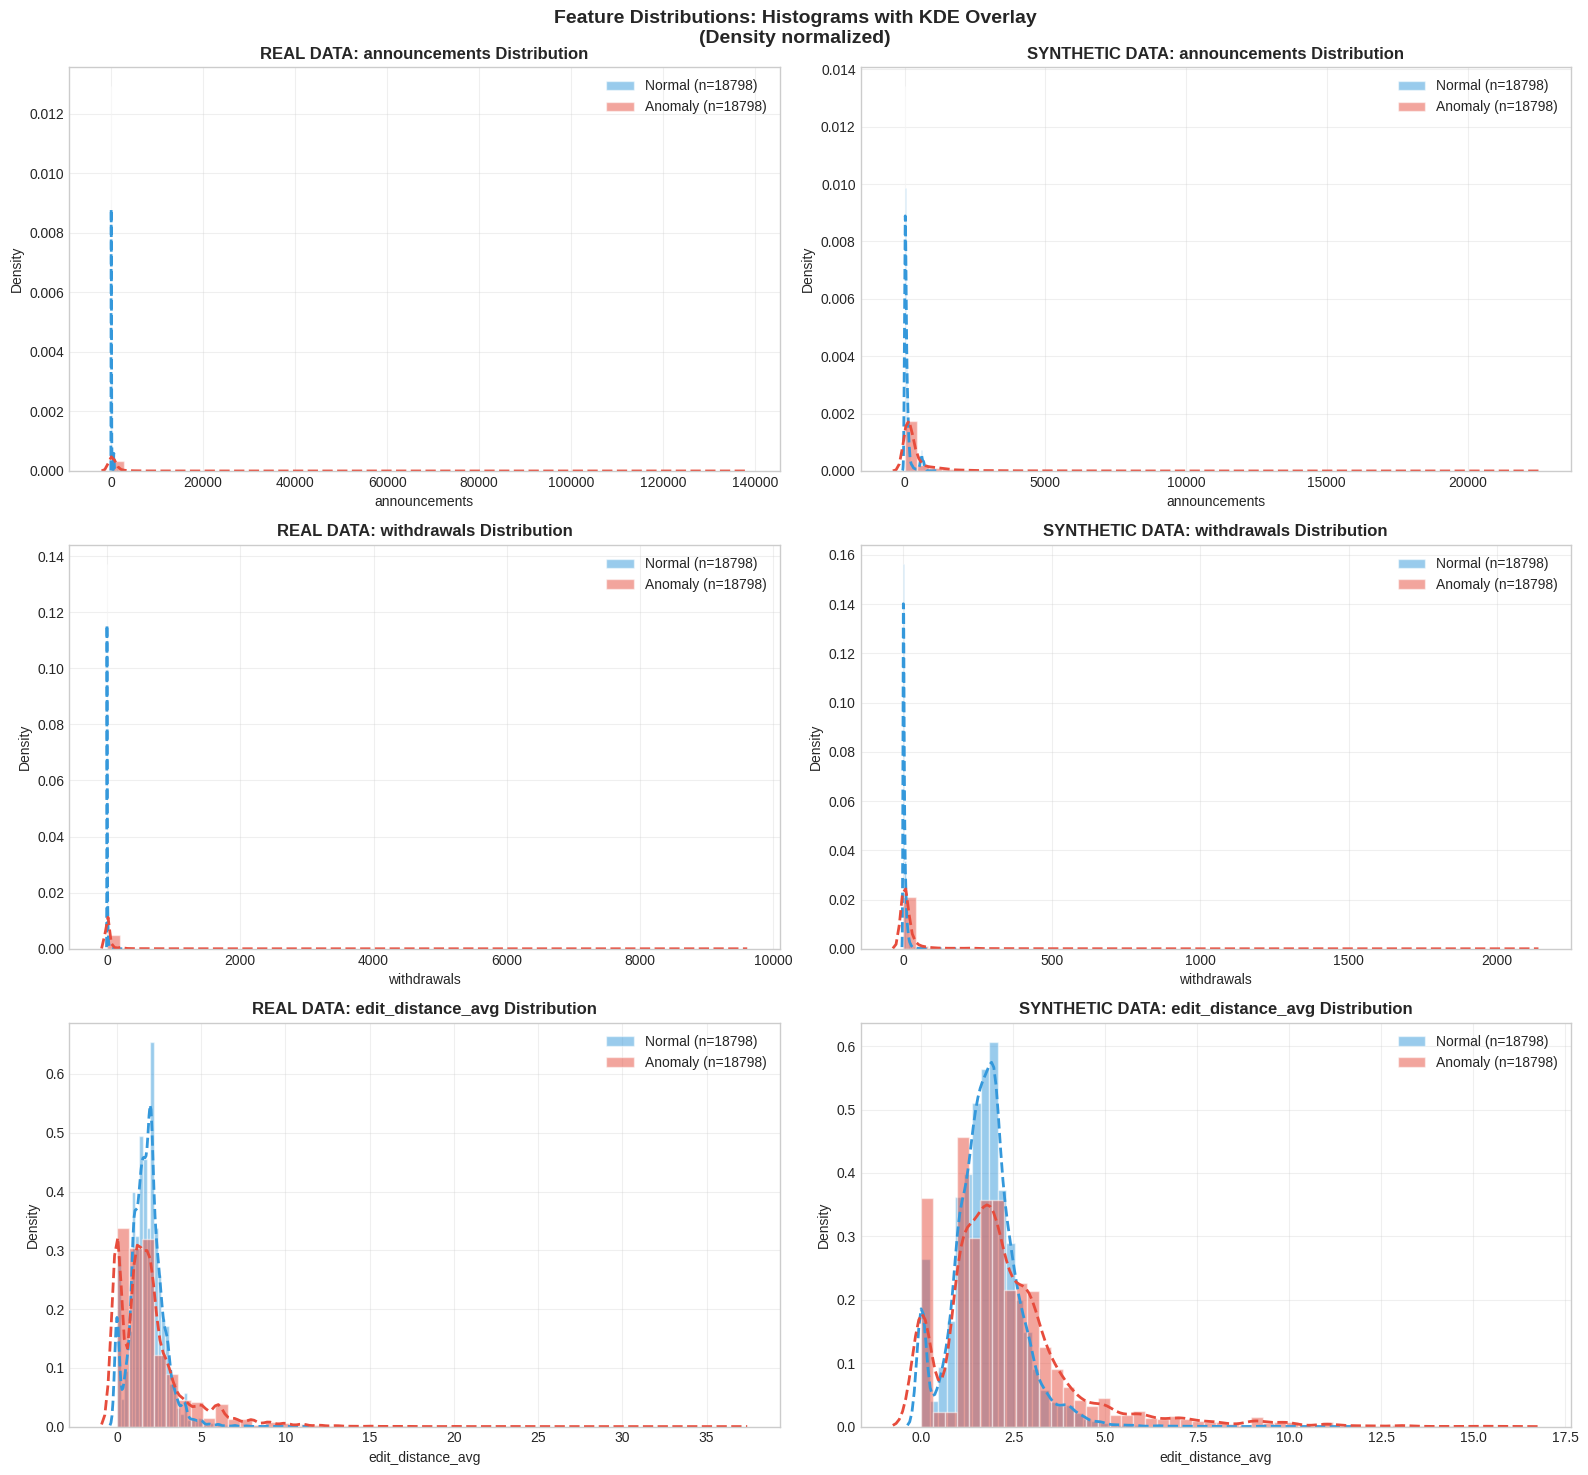

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/feature_distributions.png


In [207]:
# ========================================
# 2. HISTOGRAM / DENSITY PLOTS: Feature Distributions Overlay
# ========================================

fig, axes = plt.subplots(len(VIZ_FEATURES), 2, figsize=(16, 5*len(VIZ_FEATURES)))

for i, feature in enumerate(VIZ_FEATURES):
    # Real data - histogram with KDE
    ax1 = axes[i, 0]
    real_normal = df_real_viz[df_real_viz['label_name'] == 'Normal'][feature]
    real_anomaly = df_real_viz[df_real_viz['label_name'] == 'Anomaly'][feature]
    
    ax1.hist(real_normal, bins=50, alpha=0.5, label=f'Normal (n={len(real_normal)})', 
             color='#3498db', density=True, edgecolor='white')
    ax1.hist(real_anomaly, bins=50, alpha=0.5, label=f'Anomaly (n={len(real_anomaly)})', 
             color='#e74c3c', density=True, edgecolor='white')
    
    # Add KDE lines
    try:
        sns.kdeplot(data=real_normal, ax=ax1, color='#3498db', linewidth=2, linestyle='--')
        sns.kdeplot(data=real_anomaly, ax=ax1, color='#e74c3c', linewidth=2, linestyle='--')
    except:
        pass  # KDE may fail for some distributions
    
    ax1.set_title(f'REAL DATA: {feature} Distribution', fontsize=12, fontweight='bold')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Density')
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)
    
    # Synthetic data - histogram with KDE
    ax2 = axes[i, 1]
    synth_normal = df_synth_viz[df_synth_viz['label_name'] == 'Normal'][feature]
    synth_anomaly = df_synth_viz[df_synth_viz['label_name'] == 'Anomaly'][feature]
    
    ax2.hist(synth_normal, bins=50, alpha=0.5, label=f'Normal (n={len(synth_normal)})', 
             color='#3498db', density=True, edgecolor='white')
    ax2.hist(synth_anomaly, bins=50, alpha=0.5, label=f'Anomaly (n={len(synth_anomaly)})', 
             color='#e74c3c', density=True, edgecolor='white')
    
    try:
        sns.kdeplot(data=synth_normal, ax=ax2, color='#3498db', linewidth=2, linestyle='--')
        sns.kdeplot(data=synth_anomaly, ax=ax2, color='#e74c3c', linewidth=2, linestyle='--')
    except:
        pass
    
    ax2.set_title(f'SYNTHETIC DATA: {feature} Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('Density')
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)

plt.suptitle('Feature Distributions: Histograms with KDE Overlay\n(Density normalized)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/feature_distributions.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/feature_distributions.png")

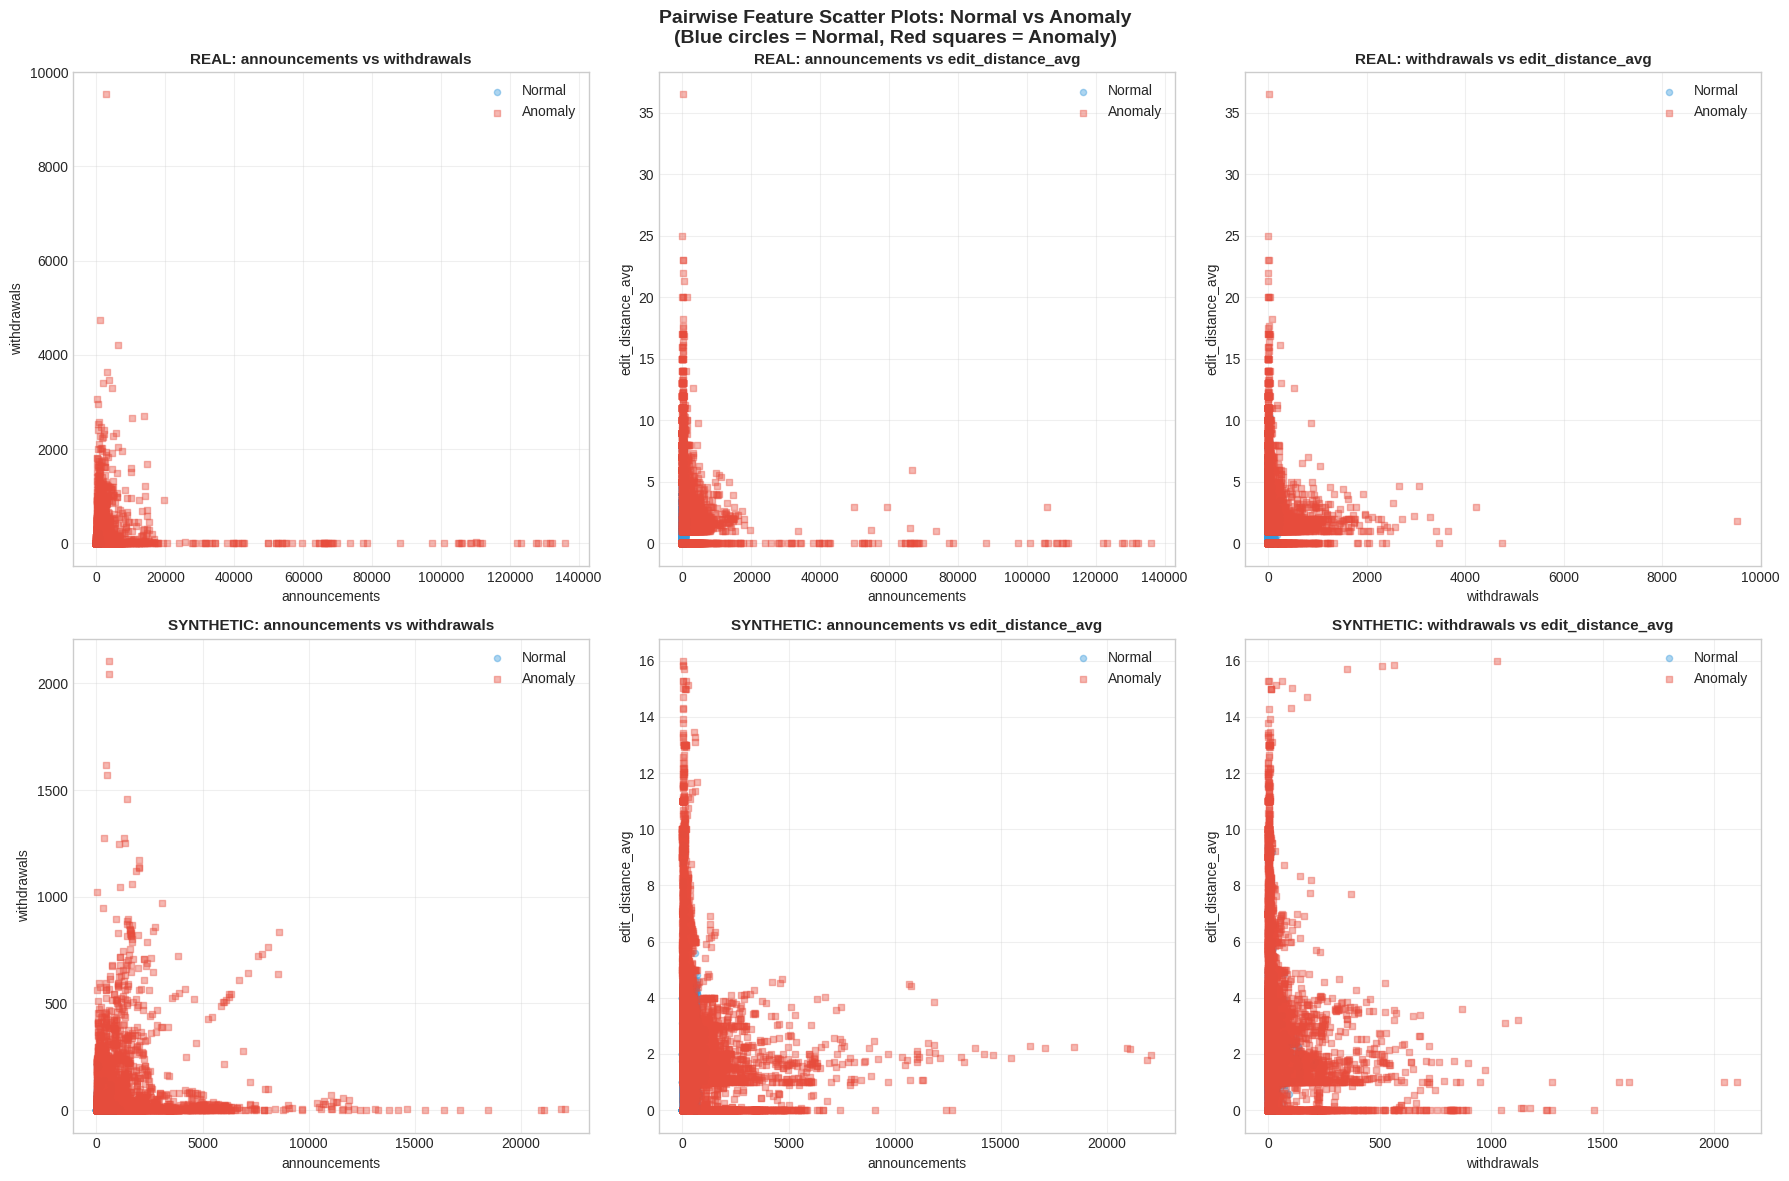

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/feature_scatter_plots.png


In [208]:
# ========================================
# 3. SCATTER PLOTS: Pairwise Feature Relationships
# ========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Feature pairs to plot
feature_pairs = [
    ('announcements', 'withdrawals'),
    ('announcements', 'edit_distance_avg'),
    ('withdrawals', 'edit_distance_avg')
]

# Row 1: Real Data
for idx, (f1, f2) in enumerate(feature_pairs):
    ax = axes[0, idx]
    for label, color, marker in [(0, '#3498db', 'o'), (1, '#e74c3c', 's')]:
        mask = y_real == label
        ax.scatter(X_real[f1][mask], X_real[f2][mask], 
                   c=color, alpha=0.4, s=20, marker=marker,
                   label='Normal' if label == 0 else 'Anomaly')
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title(f'REAL: {f1} vs {f2}', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)

# Row 2: Synthetic Data
for idx, (f1, f2) in enumerate(feature_pairs):
    ax = axes[1, idx]
    for label, color, marker in [(0, '#3498db', 'o'), (1, '#e74c3c', 's')]:
        mask = y_synthetic == label
        ax.scatter(X_synthetic[f1][mask], X_synthetic[f2][mask], 
                   c=color, alpha=0.4, s=20, marker=marker,
                   label='Normal' if label == 0 else 'Anomaly')
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title(f'SYNTHETIC: {f1} vs {f2}', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)

plt.suptitle('Pairwise Feature Scatter Plots: Normal vs Anomaly\n(Blue circles = Normal, Red squares = Anomaly)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/feature_scatter_plots.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/feature_scatter_plots.png")

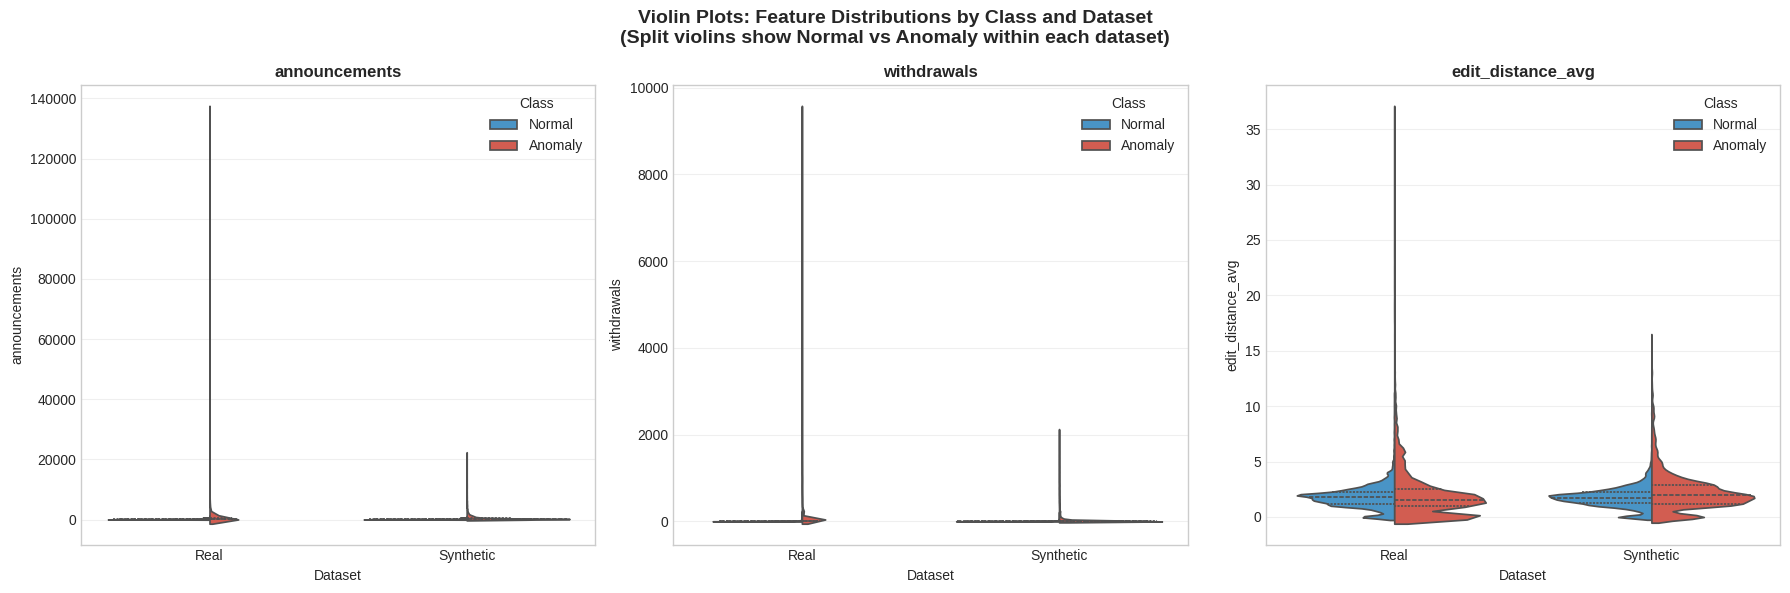

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/feature_violin_plots.png


In [209]:
# ========================================
# 4. VIOLIN PLOTS: Detailed Distribution Comparison
# ========================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, feature in enumerate(VIZ_FEATURES):
    ax = axes[i]
    
    # Combine data for violin plot
    plot_data = df_combined_viz[[feature, 'label_name', 'dataset']].copy()
    
    # Create violin plot
    sns.violinplot(data=plot_data, x='dataset', y=feature, hue='label_name', 
                   split=True, ax=ax, palette={'Normal': '#3498db', 'Anomaly': '#e74c3c'},
                   inner='quartile')
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Dataset')
    ax.set_ylabel(feature)
    ax.legend(title='Class', loc='upper right')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Violin Plots: Feature Distributions by Class and Dataset\n(Split violins show Normal vs Anomaly within each dataset)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/feature_violin_plots.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/feature_violin_plots.png")

---
## 11. Summary

In [210]:
print("="*80)
print("SUMMARY")
print("="*80)

print("\nData Used (BALANCED):")
print(f"  Real:      {len(X_real)} total (Normal: {sum(y_real==0)}, Anomaly: {sum(y_real==1)})")
print(f"  Synthetic: {len(X_synthetic)} total (Normal: {sum(y_synthetic==0)}, Anomaly: {sum(y_synthetic==1)})")
print(f"  Features:  {len(common_features_all)}")

print("\nBest F1 Scores by Regime:")
for regime in ['TRTR', 'TSTR', 'TRTS']:
    best_model = max(all_results[regime].items(), key=lambda x: x[1]['f1_score'])
    print(f"  {regime}: {best_model[0]} with F1={best_model[1]['f1_score']:.4f}")

print("\nBest AUROC by Regime:")
for regime in ['TRTR', 'TSTR', 'TRTS']:
    best_model = max(all_results[regime].items(), key=lambda x: x[1]['auroc'])
    print(f"  {regime}: {best_model[0]} with AUROC={best_model[1]['auroc']:.4f}")

print("\n" + "="*80)
print("FILES SAVED:")
print("="*80)
print(f"  {OUTPUT_DIR}/comparison_results.csv")
print(f"  {OUTPUT_DIR}/best_hyperparameters.json")
print(f"  {OUTPUT_DIR}/best_hyperparameters.txt")
print(f"  {OUTPUT_DIR}/comparison_plot.png")
print(f"  {OUTPUT_DIR}/metrics_heatmap.png")
print(f"  {OUTPUT_DIR}/feature_boxplots.png")
print(f"  {OUTPUT_DIR}/feature_distributions.png")
print(f"  {OUTPUT_DIR}/feature_scatter_plots.png")
print(f"  {OUTPUT_DIR}/feature_violin_plots.png")
print(f"  {OUTPUT_DIR}/feature_importance.png")

SUMMARY

Data Used (BALANCED):
  Real:      37596 total (Normal: 18798, Anomaly: 18798)
  Synthetic: 37596 total (Normal: 18798, Anomaly: 18798)
  Features:  27

Best F1 Scores by Regime:
  TRTR: LightGBM with F1=0.9903
  TSTR: RandomForest with F1=0.7886
  TRTS: LightGBM with F1=0.9635

Best AUROC by Regime:
  TRTR: XGBoost with AUROC=0.9985
  TSTR: RandomForest with AUROC=0.9086
  TRTS: RandomForest with AUROC=0.9980

FILES SAVED:
  /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/comparison_results.csv
  /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/best_hyperparameters.json
  /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/best_hyperparameters.txt
  /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/comparison_plot.png
  /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/metrics_heatmap.png
  /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/feature_boxplots.png
  /home/smotaa

In [211]:
# Save all results as JSON
results_dict = {
    regime: {
        model: {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in metrics.items()}
        for model, metrics in models.items()
    }
    for regime, models in all_results.items()
}

results_dict['config'] = {
    'random_state': RANDOM_STATE,
    'test_size': TEST_SIZE,
    'n_trials': N_TRIALS,
    'balanced': BALANCE_DATA,
    'n_real': len(X_real),
    'n_synthetic': len(X_synthetic),
    'n_features': len(common_features_all)
}

with open(f"{OUTPUT_DIR}/all_results.json", 'w') as f:
    json.dump(results_dict, f, indent=2)
print(f"Saved: {OUTPUT_DIR}/all_results.json")

Saved: /home/smotaali/BGP_Traffic_Generation/results/trtr_tstr_trts_smote/all_results.json
